<div id="container" style="position:relative;">
<div style="float:left"><h1>  

# weCAN: A Cancer Survivability Predictor

## Baseline Modelling and Hyperparameter Tuning

#### Author: Rahim Kaba
#### Contact: rkaba91@gmail.com
#### Date: Sept-Dec 2023
    
</h1></div>
    
<div style="position:relative; float:right">
  <img style="height:65px" src="/Cancer_Survivability_Predictor/Images/weCAN.jpg"/>
</div>    

## Table of Contents:
---
1. [Introduction](#intro)
2. [Loading and Setup](#loadingandsetup)
3. [Data Inspection](#inspection)
4. [Baseline Modeling](#base)
5. [Hyperparameter Optimization](#opt)
6. [Comparison of Baseline and Optimized Models](#compare)
7. [Conclusions](#conclude)
8. [Next Steps](#next)


---
## Introduction: <a class="anchor" id="intro"></a>

Using our final feature space from the Feature Engineering workbook, we now need need to test and optimize Machine Learning models.

Steps:
- Run different baseline models with the current feature space
- Upsample the minority classes in my target variable to increase my model's power to predict the minority classes
- Choose the best model based on different metrics: 
    - accuracy
    - precision
    - recall
    - f1
    - area under the ROC curve for each class
- Once we have chosen our best model, we will use a grid search with k fold cross validation to optimize hyperparameters and see how our optimized model compares to the baseline.

---
## Loding and Setup: <a class="anchor" id="loadingandsetup"></a>

In [1]:
#load necessary libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score 
from sklearn.svm import SVC 
from sklearn.multiclass import OneVsOneClassifier 
from sklearn.calibration import CalibratedClassifierCV
from tempfile import mkdtemp 
from sklearn.decomposition import KernelPCA, PCA
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import label_binarize 
from xgboost import XGBClassifier

#filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
#read data
df = pd.read_csv('/Users/RahimKaba/Desktop/Cancer_Survivability_Predictor/Data/my_data_no_mets_organ_primary.csv', index_col='Sample ID')

---
## Data Inspection: <a class="anchor" id="inspection"></a>

Lets just re-examine the data to get acquainted with it again. We will look at the following:
- The first few rows
- The shape of the data
- some of the basic statistics and information of the data set

In [5]:
#check out the first few rows of the data
df.head()

,Age at Sequencing,Age at Surgical Procedure,Fraction Genome Altered,Metastatic patient,Met Count,Met Site Count,MSI Score,MSI Instable,Sample coverage,TMB (nonsynonymous),Tumor Purity,Average Age,Year Group Encoded
Sample ID,,,,,,,,,,,,,
P-0000004-T01-IM3,39.74,37.03,0.2782,1,2,2,2.50,0,428,4.436621,50.0,39.1225,1
P-0000015-T01-IM3,44.44,44.42,0.3503,1,8,8,2.55,0,281,7.764087,40.0,44.6775,2
P-0000024-T01-IM3,61.33,61.00,0.3878,1,8,5,0.72,0,1016,6.654932,40.0,61.5050,3
P-0000025-T02-IM5,74.81,74.64,0.1020,1,13,8,0.15,0,1147,1.957439,30.0,73.9075,3
P-0000026-T01-IM3,71.72,71.58,0.4196,1,11,7,1.23,0,1222,4.436621,10.0,72.5350,4


In [6]:
#check the shape of the imported data
df.shape

(25771, 13)

In [7]:
#check the basic statistics of the dataframe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age at Sequencing,25771.0,62.306009,12.834100,18.290000,54.445000,63.660000,71.430000,90.000000
Age at Surgical Procedure,25771.0,61.507042,12.931434,17.160000,53.550000,62.810000,70.630000,90.000000
Fraction Genome Altered,25771.0,0.194718,0.191610,0.000000,0.029900,0.142800,0.305400,1.000000
Metastatic patient,25771.0,0.836017,0.370267,0.000000,1.000000,1.000000,1.000000,1.000000
Met Count,25771.0,3.857747,3.736564,0.000000,1.000000,3.000000,6.000000,31.000000
Met Site Count,25771.0,3.012417,2.579147,0.000000,1.000000,2.000000,5.000000,15.000000
MSI Score,25771.0,1.285021,4.636103,-1.000000,0.000000,0.230000,0.860000,53.440000
MSI Instable,25771.0,0.151139,0.358191,0.000000,0.000000,0.000000,0.000000,1.000000
Sample coverage,25771.0,660.388421,212.491289,100.000000,526.000000,653.000000,790.000000,2778.000000
TMB (nonsynonymous),25771.0,7.955109,19.448392,0.000000,2.218311,4.323490,6.917585,654.576458


In [8]:
#check the basic statistics of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25771 entries, P-0000004-T01-IM3 to P-0050568-T01-IM6
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age at Sequencing          25771 non-null  float64
 1   Age at Surgical Procedure  25771 non-null  float64
 2   Fraction Genome Altered    25771 non-null  float64
 3   Metastatic patient         25771 non-null  int64  
 4   Met Count                  25771 non-null  int64  
 5   Met Site Count             25771 non-null  int64  
 6   MSI Score                  25771 non-null  float64
 7   MSI Instable               25771 non-null  int64  
 8   Sample coverage            25771 non-null  int64  
 9   TMB (nonsynonymous)        25771 non-null  float64
 10  Tumor Purity               25771 non-null  float64
 11  Average Age                25771 non-null  float64
 12  Year Group Encoded         25771 non-null  int64  
dtypes: float64(7), int64(6)

---
## Baseline Modeling: <a class="anchor" id="base"></a>

Now that we have looked at the data, we can move onto the baseline modeling. Steps we will take are:
- Split the data into 80/20 for train/test split
- Scale the data: Use Standard Scaler, fit to the training data and transform the training and test data
- Use SMOTE to upsample the minority classes (as we saw from the feature engineering part of the project, the models were less powerful on the minority classes)
- Run the baseline models
- We will also instantiate an empty dictionary to add the metrics for each model so we can evaluate them at then end of the baseline modelling step

In [9]:
# train test split

#set X and y:

X = df.drop(columns=['Year Group Encoded'])
y = df['Year Group Encoded']

# train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#split off a validation set for hyperparameter tuning from X_train_full and y_train_full
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

In [10]:
#apply smote to the training set

# Initialize SMOTE
smote = SMOTE(random_state=42)

X_train_full_sm, y_train_full_sm = smote.fit_resample(X_train_full, y_train_full)
X_train_sm, y_train_sm = smote.fit_resample (X_train, y_train)

In [11]:
#sanity check to make sure all shapes match
print(f'Shape of: X_train_full:{X_train_full_sm.shape}, X_train:{X_train_sm.shape}, X_val:{X_val.shape}, X_test:{X_test.shape}')

#sanity check to make sure all shapes match
print(f'Shape of: y_train_full:{y_train_full_sm.shape}, y_train:{y_train_sm.shape}, y_val:{y_val.shape}, y_test:{y_test.shape}')

Shape of: X_train_full:(25400, 12), X_train:(20320, 12), X_val:(4124, 12), X_test:(5155, 12)
Shape of: y_train_full:(25400,), y_train:(20320,), y_val:(4124,), y_test:(5155,)


In [14]:
#scale the data:
import joblib

#instantiate the scaler
scaler = StandardScaler()

#fit scaler to train data
scaler.fit(X_train_full_sm)

# Save the fitted scaler - for later use
joblib.dump(scaler, 'scaler.pkl')

#transform train and test dataframes
X_train_scaled = scaler.transform(X_train_sm)
X_val_scaled = scaler.transform(X_val)
X_train_full_scaled = scaler.transform(X_train_full_sm)
X_test_scaled = scaler.transform(X_test)

In [29]:
#make a function to track all the metrics:
def add_metrics_to_dict(model_name, accuracy, precision, recall, f1_score, metrics_dict):
    # Add the metrics to the dictionary under the model's name
    metrics_dict[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }


In [30]:
#instantiate an empty dictionary to store the evaluation metrics of each baseline model
baseline_metrics = {}


---
### Baseline Logistic Multiclass Classification:
---

- We will train our Baseline Logistic model on upsampled train data and evaluate on the validation data. 
- We will check different score metrics to determine how the model is performing
- We will examine the AUC of the ROC curves for each prognosis class to see how the model distinguished one class from the rest of the classes.

In [11]:
# Initialize the model
logreg_baseline = LogisticRegression(random_state=42)

# Train the model
logreg_baseline.fit(X_train_scaled, y_train_sm)

# Make predictions on the validation data
preds_logreg_baseline = logreg_baseline.predict(X_val_scaled)

# Compute metrics
accuracy_lg_baseline = accuracy_score(y_val, preds_logreg_baseline)
precision_lg_baseline = precision_score(y_val, preds_logreg_baseline, average='weighted')
recall_lg_baseline = recall_score(y_val, preds_logreg_baseline, average='weighted')
f1_lg_baseline = f1_score(y_val, preds_logreg_baseline, average='weighted')
conf_mat_lg_baseline = confusion_matrix(y_val, preds_logreg_baseline)
clf_report_lg_baseline = classification_report(y_val, preds_logreg_baseline)

# Print metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lg_baseline}")
print(f"Precision: {precision_lg_baseline}")
print(f"Recall: {recall_lg_baseline}")
print(f"F1 Score: {f1_lg_baseline}")
print("Confusion Matrix:")
print(conf_mat_lg_baseline)
print("Classification Report:")
print(clf_report_lg_baseline)

Logistic Regression Metrics:
Accuracy: 0.5404946653734238
Precision: 0.5505307109961712
Recall: 0.5404946653734238
F1 Score: 0.5349846089015512
Confusion Matrix:
[[866 286  54  46]
 [433 557 205  75]
 [125 184 472 348]
 [ 39  19  81 334]]
Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.69      0.64      1252
           2       0.53      0.44      0.48      1270
           3       0.58      0.42      0.49      1129
           4       0.42      0.71      0.52       473

    accuracy                           0.54      4124
   macro avg       0.53      0.56      0.53      4124
weighted avg       0.55      0.54      0.53      4124



In [32]:
#add the metrics to the baseline_metrics dictionary:
add_metrics_to_dict(
    'Logistic Regression', 
    accuracy_lg_baseline, 
    precision_lg_baseline, 
    recall_lg_baseline, 
    f1_lg_baseline, 
    baseline_metrics
)

---
**Observations:**

We have fit the baseline logistic regression classifier model to the train data that was upsampled by smote and evaluated on the validation set. We can see from above that the Accuracy and F1 scores are ~54% and ~53% respecively. Though this gives us some insight into how the model is performing, we will check the AUC uunder the ROC curve to determine how the model is performing on each class individually compared to the other classes. This will tell us how the model is performing making predictions for each class. Note that the most important classes for patient prognosis are `Class 1: Very Poor Prognosis` (<1 year survival) and `Class 4: Good Prognosis` (>4years survival). In an ideal scenario we would have a larger range of survivabilities so we could have the good prognosis category to be >5 years or >10 years as would be the industry standard. But given the data we have to work with, we needed a >4 years category. 

The report indicates that the Logistic Regression model's performance is adequate to good for the classes, with all the metrics being around around 0.5 or higher. The model's predictive quality, as per these metrics, is much better than randomg guessing. The Logisgtic Regression model seems to perform similarily for all classes but the best for class 1 and class 4 respectively.


---

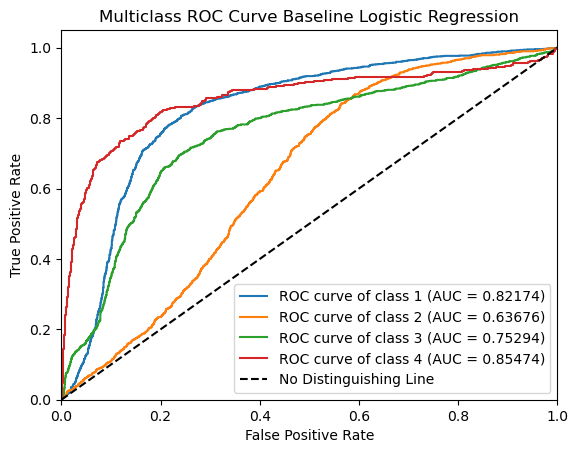

In [84]:
#check the AUC under the ROC curves

# Binarize the output
y_val_binarized_logreg_baseline = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_val_binarized_logreg_baseline.shape[1]

#get the predicted probabilities from the validation data
y_probs_logreg_baseline = logreg_baseline.predict_proba(X_val_scaled)

#instantiate empty dictionaries for each metric
fpr_log_base = dict()
tpr_log_base = dict()
roc_auc_log_base = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr_log_base[i], tpr_log_base[i], _ = roc_curve(y_val_binarized_logreg_baseline[:, i], y_probs_logreg_baseline[:, i])
    roc_auc_log_base[i] = auc(fpr_log_base[i], tpr_log_base[i])

#Plot the ROC curves:
#instantiate the figure:
plt.figure()

#for loop to plot ROC and calculate AUC for each class
for i in range(n_classes):
    plt.plot(fpr_log_base[i], tpr_log_base[i], label=f'ROC curve of class {i+1} (AUC = {roc_auc_log_base[i]:.5f})')

#plot the no distinguishing line
plt.plot([0, 1], [0, 1], 'k--', label='No Distinguishing Line')

#format axis and label axis and chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve Baseline Logistic Regression')
plt.legend(loc="lower right")
plt.show()

---
**Observations**:

Each ROC curve represents the performance of the classifier in distinguishing between a specific class and all other classes. Each line represents the true positive rate (TPR) against the false positive rate (FPR) at various threshold levels for a single class. The Area Under the Curve (AUC) provides a single value summarizing the performance across all thresholds. At AUC = 1.0, this means our model has perfect distiguishing ability. The higher this score, the better our model perofmrance.

Lets analyze the curves and the values above:

- `Class 1 (Blue curve) - Very Poor Prognosis(< 1 year survival)`: An AUC of 0.82174 suggests that the model has a good performance in distinguishing between class 1 and the other classes.
- `Class 2 (Orange curve) - Poor Prognosis(1 to < 2 years survival)`: An AUC of 0.63676 indicates that the model's ability to distinguish class 2 from the other classes is not fantastic, as it is slightly better than 0.5 which would be the AUC of no better than random guessing.
- `Class 3 (Green curve) - Intermediate Prognosis (2 to < 4 years survival)`: An AUC of 0.75294 shows that the model has a fair capability to distinguish class 3 from the others, although it is not as good as for class 1.
- `Class 4 (Red curve) - Good Prognosis (>= 4. years survival)`: An AUC of 0.85474 suggests that the model has a very good performance in distinguishing between class 4 and the other classes, even better than class 1.
- `The No Distinguishing Line (dashed line)`: This line represents a model with no discrimination capacity to differentiate between positive and negative class, essentially random guessing. The further away the ROC curve of a class is from this line towards the top left corner, the better it is at classification.

Given the infomration above, this model does quite well with distinguishing Class 1 and Class 4 relative to the other categories. This is what we want. Since the data is more narrow for the classes than we want, it is expected that the model struggles to precisely distinguish Class 2 and Class 3. These classes are close in range and given a wider range, we would expect better results for Class 2 and Class 3

---
### Baseline KNN Multiclass Classification:
---

- We will train our Baseline KNN model on upsampled train data and evaluate on the validation data. 
- We will check different score metrics to determine how the model is performing
- We will examine the AUC of the ROC curves for each prognosis class to see how the model distinguished one class from the rest of the classes.

In [13]:
#Instantiate the model & fit it to our data
KNN_baseline = KNeighborsClassifier()

#fit the model to the train data
KNN_baseline.fit(X_train_scaled, y_train_sm)

# Make predictions on the validation data
preds_KNN_baseline = KNN_baseline.predict(X_val_scaled)

# Compute metrics
accuracy_knn_baseline = accuracy_score(y_val, preds_KNN_baseline)
precision_knn_baseline = precision_score(y_val, preds_KNN_baseline, average='weighted')
recall_knn_baseline = recall_score(y_val, preds_KNN_baseline, average='weighted')
f1_knn_baseline = f1_score(y_val, preds_KNN_baseline, average='weighted')
conf_mat_knn_baseline = confusion_matrix(y_val, preds_KNN_baseline)
clf_report_knn_baseline = classification_report(y_val, preds_KNN_baseline)

# Print metrics
print("KNN Metrics:")
print(f"Accuracy: {accuracy_knn_baseline}")
print(f"Precision: {precision_knn_baseline}")
print(f"Recall: {recall_knn_baseline}")
print(f"F1 Score: {f1_knn_baseline}")
print("Confusion Matrix:")
print(conf_mat_knn_baseline)
print("Classification Report:")
print(clf_report_knn_baseline)

KNN Metrics:
Accuracy: 0.3198351115421921
Precision: 0.32436016939245793
Recall: 0.3198351115421921
F1 Score: 0.3195370242407646
Confusion Matrix:
[[503 349 227 173]
 [481 400 252 137]
 [346 313 302 168]
 [152 108  99 114]]
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.40      0.37      1252
           2       0.34      0.31      0.33      1270
           3       0.34      0.27      0.30      1129
           4       0.19      0.24      0.21       473

    accuracy                           0.32      4124
   macro avg       0.30      0.31      0.30      4124
weighted avg       0.32      0.32      0.32      4124



In [33]:
#add the metrics to the baseline_metrics dictionary:
add_metrics_to_dict(
    'KNN', 
    accuracy_knn_baseline, 
    precision_knn_baseline, 
    recall_knn_baseline, 
    f1_knn_baseline, 
    baseline_metrics
)

---
**Observations:**

We have fit the baseline KNN model to the train data that was upsampled by smote and evaluated on the validation set. We can see from above that the Accuracy and F1 scores are both ~32%. In all metrics and for all classes, this model does worse than Logistic Regression Classifier. Though this gives us some insight into how the model is performing, we will check the AUC uunder the ROC curve to determine how the model is performing on each class individually compared to the other classes. This will tell us how the model is performing making predictions for each class. Note that the most important classes for patient prognosis are `Class 1: Very Poor Prognosis` (<1 year survival) and `Class 4: Good Prognosis` (>4years survival). In an ideal scenario we would have a larger range of survivabilities so we could have the good prognosis category to be >5 years or >10 years as would be the industry standard. But given the data we have to work with, we needed a >4 years category. 

The report indicates that the KNN model's performance is low for the classes, with all the metrics being around 0.4 or lower. The model's predictive quality, as per these metrics, is close to random guessing or slightly higher. The KNN model seems to perform similarily for all classes, except quite poorly for class 4 which is the hardest for this model to predict.


---

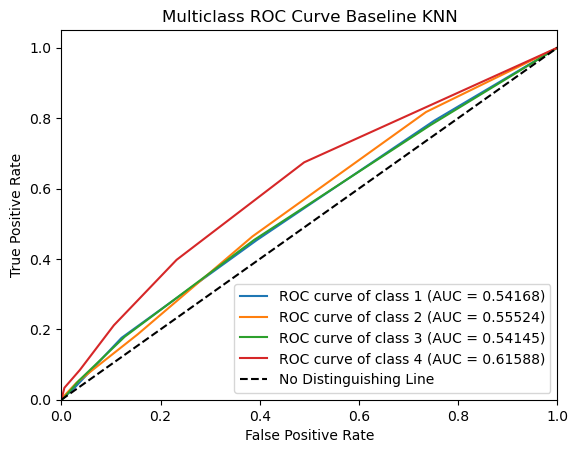

In [14]:
#check the AUC under the ROC curves

# Binarize the output
y_val_binarized_KNN = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_val_binarized_KNN.shape[1]

#get the predicted probabilities from the validation data
y_probs_KNN_baseline = KNN_baseline.predict_proba(X_val_scaled)

#instantiate empty dictionaries for each metric
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized_KNN[:, i], y_probs_KNN_baseline[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


#Plot the ROC curves:
#instantiate the figure:
plt.figure()

#for loop to plot ROC and calculate AUC for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i+1} (AUC = {roc_auc[i]:.5f})')

#plot the no distinguishing line
plt.plot([0, 1], [0, 1], 'k--', label='No Distinguishing Line')

#format axis and label axis and chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve Baseline KNN')
plt.legend(loc="lower right")
plt.show()

---
**Observations**:

Each ROC curve represents the performance of the classifier in distinguishing between a specific class and all other classes. Each line represents the true positive rate (TPR) against the false positive rate (FPR) at various threshold levels for a single class. The Area Under the Curve (AUC) provides a single value summarizing the performance across all thresholds. At AUC = 1.0, this means our model has perfect distiguishing ability. The higher this score, the better our model perofmrance.

Lets analyze the curves and the values above:


- `Class 1 (Blue curve) - Very Poor Prognosis(< 1 year survival)`:  An AUC of 0.54168 is just slightly better than random guessing (which would have an AUC of 0.5). This indicates that the classifier is not performing well in distinguishing between class 1 and other classes.
- `Class 2 (Orange curve) - Poor Prognosis(1 to < 2 years survival)`: An AUC of 0.55524 shows a performance marginally better than random chance. This suggests that the classifier's ability to distinguish class 2 from the other classes is very limited.
- `Class 3 (Green curve) - Intermediate Prognosis (2 to < 4 years survival)`: An AUC of 0.54145 is very close to 0.5, implying that the model is not effective in discriminating class 3 from the other classes.
- `Class 4 (Red curve) - Good Prognosis (>= 4. years survival)`: An AUC of 0.61588 is the highest among the four classes, but it still indicates only a fair classification ability. It's better than random chance but not by a large margin.
- `The No Distinguishing Line (dashed line)`: This line represents a model with no discrimination capacity to differentiate between positive and negative class, essentially random guessing. The further away the ROC curve of a class is from this line towards the top left corner, the better it is at classification.

Given the information above, the KNN classifier has quite poor power for this data set and making predictions

---
### Baseline SVM-OvA Multiclass Classification:
---

- We will train our Baseline SVM-OvA on upsampled train data and evaluate on the validation data. 
- We will check different score metrics to determine how the model is performing
- We will examine the AUC of the ROC curves for each prognosis class to see how the model distinguished one class from the rest of the classes.

In [15]:
# Instantiate the model
OvA_baseline = SVC(random_state=42, decision_function_shape='ovr', probability=True)

#fit the model to the train data
OvA_baseline.fit(X_train_scaled, y_train_sm)

# Make predictions on the validation data
preds_OvA_baseline = OvA_baseline.predict(X_val_scaled)

# Compute metrics
accuracy_OvA_baseline = accuracy_score(y_val, preds_OvA_baseline)
precision_OvA_baseline = precision_score(y_val, preds_OvA_baseline, average='weighted')
recall_OvA_baseline = recall_score(y_val, preds_OvA_baseline, average='weighted')
f1_OvA_baseline = f1_score(y_val, preds_OvA_baseline, average='weighted')
conf_mat_OvA_baseline = confusion_matrix(y_val, preds_OvA_baseline)
clf_report_OvA_baseline = classification_report(y_val, preds_OvA_baseline)

# Print metrics
print("OvA Metrics:")
print(f"Accuracy: {accuracy_OvA_baseline}")
print(f"Precision: {precision_OvA_baseline}")
print(f"Recall: {recall_OvA_baseline}")
print(f"F1 Score: {f1_OvA_baseline}")
print("Confusion Matrix:")
print(conf_mat_OvA_baseline)
print("Classification Report:")
print(clf_report_OvA_baseline)

OvA Metrics:
Accuracy: 0.39645974781765275
Precision: 0.405184647093584
Recall: 0.39645974781765275
F1 Score: 0.3928921676613147
Confusion Matrix:
[[436 504 191 121]
 [304 635 200 131]
 [178 390 338 223]
 [ 64  91  92 226]]
Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.35      0.39      1252
           2       0.39      0.50      0.44      1270
           3       0.41      0.30      0.35      1129
           4       0.32      0.48      0.39       473

    accuracy                           0.40      4124
   macro avg       0.39      0.41      0.39      4124
weighted avg       0.41      0.40      0.39      4124



In [34]:
#add the metrics to the baseline_metrics dictionary:

add_metrics_to_dict(
    'SVM_OvA', 
    accuracy_OvA_baseline, 
    precision_OvA_baseline, 
    recall_OvA_baseline, 
    f1_OvA_baseline, 
    baseline_metrics
)

---
**Observations:**

We have fit the baseline OvA model to the train data that was upsampled by smote and evaluated on the validation set. We can see from above that the Accuracy and F1 scores are ~40% and ~39% respectively. This model seems to do better than the KNN classifier but worse than Logistic Regression. Though this gives us some insight into how the model is performing, we will check the AUC uunder the ROC curve to determine how the model is performing on each class individually compared to the other classes. This will tell us how the model is performing making predictions for each class. Note that the most important classes for patient prognosis are `Class 1: Very Poor Prognosis` (<1 year survival) and `Class 4: Good Prognosis` (>4years survival). In an ideal scenario we would have a larger range of survivabilities so we could have the good prognosis category to be >5 years or >10 years as would be the industry standard. But given the data we have to work with, we needed a >4 years category. 

The report indicates that the OvA model's performance is adequate for the classes, with all the metrics being around 0.3 to 0.5. The model's predictive quality, as per these metrics, is close to random guessing or slightly higher. The OvA model seems to perform similarily for all classes.


---

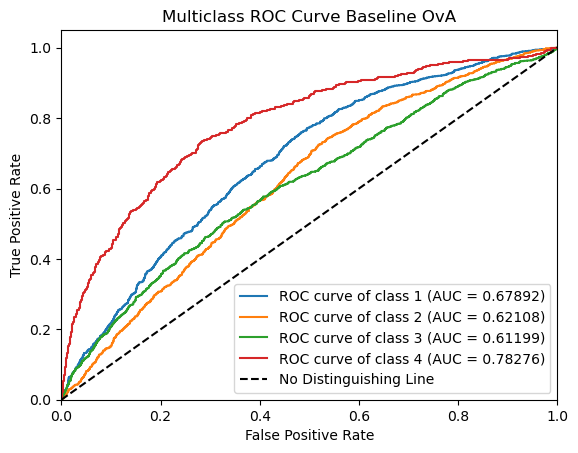

In [16]:
#check the AUC under the ROC curves

# Binarize the output
y_val_binarized_OvA = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_val_binarized_OvA.shape[1]

#get the predicted probabilities from the validation data
y_probs_OvA_baseline = OvA_baseline.predict_proba(X_val_scaled)

#instantiate empty dictionaries for each metric
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized_OvA[:, i], y_probs_OvA_baseline[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Plot the ROC curves:
#instantiate the figure:
plt.figure()

#for loop to plot ROC and calculate AUC for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i+1} (AUC = {roc_auc[i]:.5f})')

#plot the no distinguishing line
plt.plot([0, 1], [0, 1], 'k--', label='No Distinguishing Line')

#format axis and label axis and chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve Baseline OvA')
plt.legend(loc="lower right")
plt.show()

---
**Observations**:

Each ROC curve represents the performance of the classifier in distinguishing between a specific class and all other classes. Each line represents the true positive rate (TPR) against the false positive rate (FPR) at various threshold levels for a single class. The Area Under the Curve (AUC) provides a single value summarizing the performance across all thresholds. At AUC = 1.0, this means our model has perfect distiguishing ability. The higher this score, the better our model perofmrance.

Lets analyze the curves and the values above:


- `Class 1 (Blue curve) - Very Poor Prognosis(< 1 year survival)`: An AUC of 0.67892 suggests that the model has a fair ability to distinguish between class 1 and the other classes. It's not close to 1, which would indicate perfect classification, but it is significantly better than random guessing (AUC of 0.5).
- `Class 2 (Orange curve) - Poor Prognosis(1 to < 2 years survival)`: An AUC of 0.62108 indicates a poor ability to distinguish class 2 from the others. The model performs better than random guessing but not by a wide margin.
- `Class 3 (Green curve) - Intermediate Prognosis (2 to < 4 years survival)`: An AUC of 0.61199 also indicates a poor performance, only slightly better than random guessing. This suggests the model has difficulty distinguishing class 3 from the others.
- `Class 4 (Red curve) - Good Prognosis (>= 4. years survival)`: An AUC of 0.78276 shows a good performance, suggesting that the model is much better at distinguishing class 4 from other classes compared to its performance with the other classes.
- `The No Distinguishing Line (dashed line)`: This line represents a model with no discrimination capacity to differentiate between positive and negative class, essentially random guessing. The further away the ROC curve of a class is from this line towards the top left corner, the better it is at classification.

Based on this information above, the OvA classifier is better than the KNN classifier but still not as good as the Logistic Regression classifier.


---
### Baseline SVM-OvO Multiclass Classification:
---

- We will train our Baseline SVM-OvO on upsampled train data and evaluate on the validation data. 
- We will check different score metrics to determine how the model is performing
- We will examine the AUC of the ROC curves for each prognosis class to see how the model distinguished one class from the rest of the classes.

In [17]:
#instantiate the modl
OvO_baseline = CalibratedClassifierCV(OneVsOneClassifier(SVC(random_state=42, probability=True)))

#fit the model to the train data
OvO_baseline.fit(X_train_scaled, y_train_sm)

# Make predictions on the validation data
preds_OvO_baseline = OvO_baseline.predict(X_val_scaled)

# Compute metrics
accuracy_OvO_baseline = accuracy_score(y_val, preds_OvO_baseline)
precision_OvO_baseline = precision_score(y_val, preds_OvO_baseline, average='weighted')
recall_OvO_baseline = recall_score(y_val, preds_OvO_baseline, average='weighted')
f1_OvO_baseline = f1_score(y_val, preds_OvO_baseline, average='weighted')
conf_mat_OvO_baseline = confusion_matrix(y_val, preds_OvO_baseline)
clf_report_OvO_baseline = classification_report(y_val, preds_OvO_baseline)

# Print metrics
print("OvO Metrics:")
print(f"Accuracy: {accuracy_OvO_baseline}")
print(f"Precision: {precision_OvO_baseline}")
print(f"Recall: {recall_OvO_baseline}")
print(f"F1 Score: {f1_OvO_baseline}")
print("Confusion Matrix:")
print(conf_mat_OvO_baseline)
print("Classification Report:")
print(clf_report_OvO_baseline)

OvO Metrics:
Accuracy: 0.3877303588748788
Precision: 0.4016541981763333
Recall: 0.3877303588748788
F1 Score: 0.38163175603948984
Confusion Matrix:
[[472 443 158 179]
 [344 588 167 171]
 [206 354 265 304]
 [ 68  75  56 274]]
Classification Report:
              precision    recall  f1-score   support

           1       0.43      0.38      0.40      1252
           2       0.40      0.46      0.43      1270
           3       0.41      0.23      0.30      1129
           4       0.30      0.58      0.39       473

    accuracy                           0.39      4124
   macro avg       0.39      0.41      0.38      4124
weighted avg       0.40      0.39      0.38      4124



In [35]:
#add the metrics to the baseline_metrics dictionary:
add_metrics_to_dict(
    'SVM_OvO', 
    accuracy_OvO_baseline, 
    precision_OvO_baseline, 
    recall_OvO_baseline, 
    f1_OvO_baseline, 
    baseline_metrics
)

---
**Observations:**

We have fit the baseline OvO model to the train data that was upsampled by smote and evaluated on the validation set. We can see from above that the Accuracy and F1 scores are both ~39%. This model seems to do better in some metrics for certain classes than OvA but worse than Logistic Regression. Though this gives us some insight into how the model is performing, we will check the AUC uunder the ROC curve to determine how the model is performing on each class individually compared to the other classes. This will tell us how the model is performing making predictions for each class. Note that the most important classes for patient prognosis are `Class 1: Very Poor Prognosis` (<1 year survival) and `Class 4: Good Prognosis` (>4years survival). In an ideal scenario we would have a larger range of survivabilities so we could have the good prognosis category to be >5 years or >10 years as would be the industry standard. But given the data we have to work with, we needed a >4 years category. 

The report indicates that the OvO model's performance is adequate for the classes, with all the metrics being around 0.3 and 0.6. The model's predictive quality, as per these metrics, is close to random guessing or slightly higher. The OvO model seems to perform similarily for all classes.

---

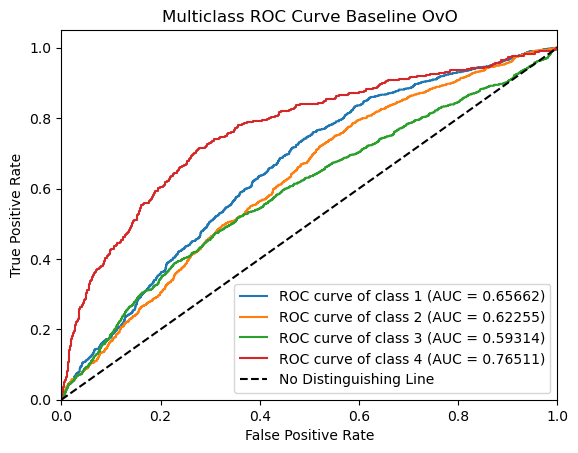

In [18]:
#check the AUC under the ROC curves

# Binarize the output
y_val_binarized_OvO = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_val_binarized_OvO.shape[1]

#get the predicted probabilities from the validation data
y_probs_OvO_baseline = OvO_baseline.predict_proba(X_val_scaled)

#instantiate empty dictionaries for each metric
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized_OvO[:, i], y_probs_OvO_baseline[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Plot the ROC curves:
#instantiate the figure:
plt.figure()

#for loop to plot ROC and calculate AUC for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i+1} (AUC = {roc_auc[i]:.5f})')

#plot the no distinguishing line
plt.plot([0, 1], [0, 1], 'k--', label='No Distinguishing Line')

#format axis and label axis and chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve Baseline OvO')
plt.legend(loc="lower right")
plt.show()

---
**Observations**:

Each ROC curve represents the performance of the classifier in distinguishing between a specific class and all other classes. Each line represents the true positive rate (TPR) against the false positive rate (FPR) at various threshold levels for a single class. The Area Under the Curve (AUC) provides a single value summarizing the performance across all thresholds. At AUC = 1.0, this means our model has perfect distiguishing ability. The higher this score, the better our model perofmrance.

Lets analyze the curves and the values above:

- `Class 1 (Blue curve) - Very Poor Prognosis(< 1 year survival)`: An AUC of 0.65662 indicates that the classifier's ability to distinguish between class 1 and the other classes is moderately better than random guessing (which would be an AUC of 0.5). However, there is still significant room for improvement.
- `Class 2 (Orange curve) - Poor Prognosis(1 to < 2 years survival)`: An AUC of 0.62255 shows that the classifier's performance for class 2 is only slightly better than random guessing. This suggests that the classifier struggles to differentiate class 2 from the other classes.
- `Class 3 (Green curve) - Intermediate Prognosis (2 to < 4 years survival)`: An AUC of 0.59314 is close to random guessing and suggests poor performance in distinguishing class 3 from the others. It indicates the classifier often confuses class 3 with other classes.
- `Class 4 (Red curve) - Good Prognosis (>= 4. years survival)`: An AUC of 0.76511 indicates a good ability to distinguish class 4 from the other classes. Among all the classes, the classifier performs best at identifying class 4.
- `The No Distinguishing Line (dashed line)`: This line represents a model with no discrimination capacity to differentiate between positive and negative class, essentially random guessing. The further away the ROC curve of a class is from this line towards the top left corner, the better it is at classification.

Based on these results, the OvO classifier does marginally better for distringuishing all classes than the OvA model except for class 3. It is a better model however, it still lacks power compared to the Logistic Regression classification model and is much more computationally heavy.

---
### Baseline Decision Tree Classifier:
---

- We will train our Baseline Decision Tree Classifier on upsampled train data and evaluate on the validation data. 
    - Note for Decision Tree, we do not need to use scaled data so we will use the upsampled unscaled data for fit and evaluation.
- We will check different score metrics to determine how the model is performing
- We will examine the AUC of the ROC curves for each prognosis class to see how the model distinguished one class from the rest of the classes.


In [19]:
# Initialize the model
DT_baseline = DecisionTreeClassifier(random_state=42)

# Train the model to the unscaled but upsampled train data
DT_baseline.fit(X_train_sm, y_train_sm)

# Make predictions on the unscaled validation data 
preds_DT_baseline = DT_baseline.predict(X_val)

# Compute metrics
accuracy_dt_baseline = accuracy_score(y_val, preds_DT_baseline)
precision_dt_baseline = precision_score(y_val, preds_DT_baseline, average='weighted')
recall_dt_baseline = recall_score(y_val, preds_DT_baseline, average='weighted')
f1_dt_baseline = f1_score(y_val, preds_DT_baseline, average='weighted')
conf_mat_dt_baseline = confusion_matrix(y_val, preds_DT_baseline)
clf_report_dt_baseline = classification_report(y_val, preds_DT_baseline)

# Print metrics
print("Decision Tree Metrics:")
print(f"Accuracy: {accuracy_dt_baseline}")
print(f"Precision: {precision_dt_baseline}")
print(f"Recall: {recall_dt_baseline}")
print(f"F1 Score: {f1_dt_baseline}")
print("Confusion Matrix:")
print(conf_mat_dt_baseline)
print("Classification Report:")
print(clf_report_dt_baseline)

Decision Tree Metrics:
Accuracy: 0.30819592628516
Precision: 0.3110817372450835
Recall: 0.30819592628516
F1 Score: 0.3090833411470253
Confusion Matrix:
[[380 379 316 177]
 [349 409 395 117]
 [310 329 344 146]
 [117  93 125 138]]
Classification Report:
              precision    recall  f1-score   support

           1       0.33      0.30      0.32      1252
           2       0.34      0.32      0.33      1270
           3       0.29      0.30      0.30      1129
           4       0.24      0.29      0.26       473

    accuracy                           0.31      4124
   macro avg       0.30      0.31      0.30      4124
weighted avg       0.31      0.31      0.31      4124



In [36]:
#add the metrics to the baseline_metrics dictionary:

add_metrics_to_dict(
    'DT', 
    accuracy_dt_baseline, 
    precision_dt_baseline, 
    recall_dt_baseline, 
    f1_dt_baseline, 
    baseline_metrics
)

---
**Observations:**

We have fit the baseline Decision Tree Classifier model to the unscaled train data that was upsampled by smote and evaluated on the unscaled validation set. We can see from above that the Accuracy and F1 scores are both ~31%. This model seems to not perform well. Though this gives us some insight into how the model is performing, we will check the AUC uunder the ROC curve to determine how the model is performing on each class individually compared to the other classes. This will tell us how the model is performing making predictions for each class. Note that the most important classes for patient prognosis are `Class 1: Very Poor Prognosis` (<1 year survival) and `Class 4: Good Prognosis` (>4years survival). In an ideal scenario we would have a larger range of survivabilities so we could have the good prognosis category to be >5 years or >10 years as would be the industry standard. But given the data we have to work with, we needed a >4 years category. 

The report indicates that the DT model's performance is not very high for any of the classes, with all the metrics being around 0.3 or lower. The model's predictive quality, as per these metrics, is close to random guessing, especially for class 4, which has the lowest scores across precision, recall, and F1, coupled with the lowest support, indicating that it is the hardest class for the model to predict accurately.

---

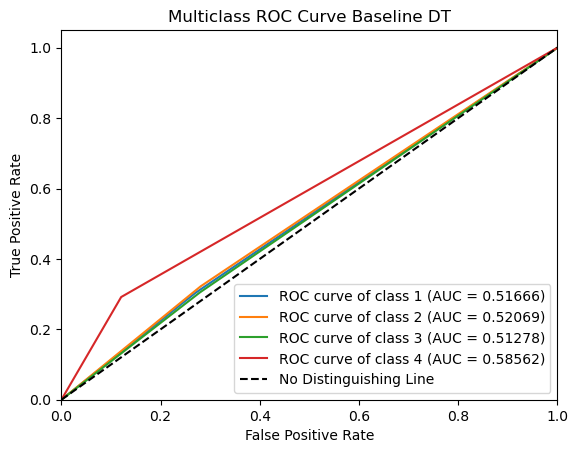

In [20]:
#check the AUC under the ROC curves

# Binarize the output
y_val_binarized_DT = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_val_binarized_DT.shape[1]

#get the predicted probabilities from the validation data
y_probs_DT_baseline = DT_baseline.predict_proba(X_val)

#instantiate empty dictionaries for each metric
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized_DT[:, i], y_probs_DT_baseline[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Plot the ROC curves:

#instantiate the figure:
plt.figure()

#for loop to plot ROC and calculate AUC for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i+1} (AUC = {roc_auc[i]:.5f})')

#plot the no distinguishing line
plt.plot([0, 1], [0, 1], 'k--', label='No Distinguishing Line')

#format axis and label axis and chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve Baseline DT')
plt.legend(loc="lower right")
plt.show()

---
**Observations**:

Each ROC curve represents the performance of the classifier in distinguishing between a specific class and all other classes. Each line represents the true positive rate (TPR) against the false positive rate (FPR) at various threshold levels for a single class. The Area Under the Curve (AUC) provides a single value summarizing the performance across all thresholds. At AUC = 1.0, this means our model has perfect distiguishing ability. The higher this score, the better our model perofmrance.

Lets analyze the curves and the values above:

- `Class 1 (Blue curve) - Very Poor Prognosis(< 1 year survival)`: An AUC of 0.51666, which is very close to 0.5, the AUC value for a random classifier with no discriminative ability. This indicates that the model's capability to distinguish between class 1 and the other classes is almost no better than random guessing.

- `Class 2 (Orange curve) - Poor Prognosis(1 to < 2 years survival)`:  An AUC of 0.52069 is only slightly above 0.5, suggesting that the model's ability to distinguish class 2 from the other classes is marginally better than flipping a coin.

- `Class 3 (Green curve) - Intermediate Prognosis (2 to < 4 years survival)`: An AUC of 0.51278 is also near 0.5, showing that the classifier's performance for class 3 is nearly equivalent to random guessing.

- `Class 4 (Red curve) - Good Prognosis (>= 4. years survival)`: An AUC of 0.58562 shows a better performance compared to the other classes, but it's still considered moderate. It's the furthest from 0.5 among the four classes, indicating that the model is best at distinguishing class 4 from the others, though not with high confidence.

- `The No Distinguishing Line (dashed line)`: This line represents a model with no discrimination capacity to differentiate between positive and negative class, essentially random guessing. The further away the ROC curve of a class is from this line towards the top left corner, the better it is at classification.

Overall, the ROC curves are quite close to the "No Distinguishing Line" (dashed line), indicating that the Decision Tree classifier has limited ability to distinguish between the classes for this particular dataset.

---
### Baseline XGBoost Classifier:
---

- We will train our Baseline XGBoost on upsampled train data and evaluate on the validation data. 
- We will check different score metrics to determine how the model is performing
- We will examine the AUC of the ROC curves for each prognosis class to see how the model distinguished one class from the rest of the classes.


In [21]:
#XGBoost expacts classes to range from 0-1 so we need to adjust them
y_train_adjusted = y_train_sm - 1
y_val_adjusted = y_val - 1

# Initialize the model
xgb_baseline = XGBClassifier(random_state=42, eval_metric='auc')

# Train the model
xgb_baseline.fit(X_train_scaled, y_train_adjusted)

# Make predictions
preds_xgb_baseline = xgb_baseline.predict(X_val_scaled)

# Compute metrics
accuracy_xgb_baseline = accuracy_score(y_val_adjusted, preds_xgb_baseline)
precision_xgb_baseline = precision_score(y_val_adjusted, preds_xgb_baseline, average='weighted')
recall_xgb_baseline = recall_score(y_val_adjusted, preds_xgb_baseline, average='weighted')
f1_xgb_baseline = f1_score(y_val_adjusted, preds_xgb_baseline, average='weighted')
conf_mat_xgb_baseline = confusion_matrix(y_val_adjusted, preds_xgb_baseline)
clf_report_xgb_baseline = classification_report(y_val_adjusted, preds_xgb_baseline)

# Print metrics
print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_xgb_baseline}")
print(f"Precision: {precision_xgb_baseline}")
print(f"Recall: {recall_xgb_baseline}")
print(f"F1 Score: {f1_xgb_baseline}")
print("Confusion Matrix:")
print(conf_mat_xgb_baseline)
print("Classification Report:")
print(clf_report_xgb_baseline)

XGBoost Metrics:
Accuracy: 0.5157613967022309
Precision: 0.5155468562516474
Recall: 0.5157613967022309
F1 Score: 0.5153900298426631
Confusion Matrix:
[[750 325 114  63]
 [338 600 281  51]
 [144 348 523 114]
 [ 50  41 128 254]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.60      0.59      1252
           1       0.46      0.47      0.46      1270
           2       0.50      0.46      0.48      1129
           3       0.53      0.54      0.53       473

    accuracy                           0.52      4124
   macro avg       0.52      0.52      0.52      4124
weighted avg       0.52      0.52      0.52      4124



In [37]:
#add the metrics to the baseline_metrics dictionary:

add_metrics_to_dict(
    'XGBoost', 
    accuracy_xgb_baseline, 
    precision_xgb_baseline, 
    recall_xgb_baseline, 
    f1_xgb_baseline, 
    baseline_metrics
)

---
**Observations:**

Note, the classes in the classification report are adjusted from 0 to 3. 1 must be added to each class to match those of our target variable.

We have fit the baseline XGBoost model to the train data that was upsampled by smote and evaluated on the validation set. We can see from above that the Accuracy and F1 scores are both ~52%. This model seems to perform well. Though this gives us some insight into how the model is performing, we will check the AUC uunder the ROC curve to determine how the model is performing on each class individually compared to the other classes. This will tell us how the model is performing making predictions for each class. Note that the most important classes for patient prognosis are `Class 1: Very Poor Prognosis` (<1 year survival) and `Class 4: Good Prognosis` (>4years survival). In an ideal scenario we would have a larger range of survivabilities so we could have the good prognosis category to be >5 years or >10 years as would be the industry standard. But given the data we have to work with, we needed a >4 years category. 

From this report, it can be inferred that the model performs relatively uniformly across the different classes with a slight tendency to perform better on class 1 and 4 compared to class 2 and 3. The overall accuracy suggests that the model is correctly predicting more than half of the time, which is better than random guessing but still leaves room for improvement.

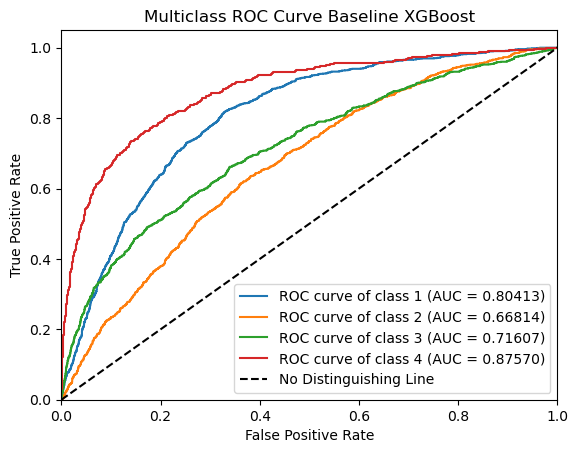

In [85]:
#check the AUC under the ROC curves

# Binarize the output
y_val_binarized_xgb = label_binarize(y_val_adjusted, classes=np.unique(y_val_adjusted))
n_classes = y_val_binarized_xgb.shape[1]

#get the predicted probabilities from the validation data
y_probs_xgb_baseline = xgb_baseline.predict_proba(X_val_scaled)

#instantiate empty dictionaries for each metric
fpr_xgb_base = dict()
tpr_xgb_base = dict()
roc_auc_xgb_base = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr_xgb_base[i], tpr_xgb_base[i], _ = roc_curve(y_val_binarized_xgb[:, i], y_probs_xgb_baseline[:, i])
    roc_auc_xgb_base[i] = auc(fpr_xgb_base[i], tpr_xgb_base[i])

# Plot all ROC curves

#instantiate the figure
plt.figure()

#for loop to plot ROC and calculate AUC for each class
for i in range(n_classes):
    plt.plot(fpr_xgb_base[i], tpr_xgb_base[i], label=f'ROC curve of class {i+1} (AUC = {roc_auc_xgb_base[i]:.5f})')

#plot the no distinguishing line
plt.plot([0, 1], [0, 1], 'k--', label='No Distinguishing Line')

#format axis and label axis and chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve Baseline XGBoost')
plt.legend(loc="lower right")
plt.show()

---
**Observations**:

Each ROC curve represents the performance of the classifier in distinguishing between a specific class and all other classes. Each line represents the true positive rate (TPR) against the false positive rate (FPR) at various threshold levels for a single class. The Area Under the Curve (AUC) provides a single value summarizing the performance across all thresholds. At AUC = 1.0, this means our model has perfect distiguishing ability. The higher this score, the better our model perofmrance.

Lets analyze the curves and the values above:

- `Class 1 (Blue curve) - Very Poor Prognosis(< 1 year survival)`: An AUC of 0.80413 indicates a good ability of the model to discriminate between class 1 and not class 1. This is considered a strong performance.
- `Class 2 (Orange curve) - Poor Prognosis(1 to < 2 years survival)`: An AUC of 0.66814 suggests a moderate discrimination ability for class 2. It's better than random guessing (AUC of 0.5) but indicates room for improvement.
- `Class 3 (Green curve) - Intermediate Prognosis (2 to < 4 years survival)`: An AUC of 0.71607 also shows moderate performance, which is better than class 2 but still not as good as class 1.
- `Class 4 (Red curve) - Good Prognosis (>= 4. years survival)`: An AUC of 0.87570 indicates a very good performance and suggests that the model is quite capable of distinguishing class 4 from the other classes.
- `The No Distinguishing Line (dashed line)`: This line represents a model with no discrimination capacity to differentiate between positive and negative class, essentially random guessing. The further away the ROC curve of a class is from this line towards the top left corner, the better it is at classification.

Overall, the ROC curves and AUC scores seem to do much better than the KNN, OvA, OvO, DT models and quite comparable to the Logistic Regression model. 


### Evaluation of Baseline models:

Here we will call our Baseline Model Metrics dictionary and represent it in a Pandas Data Frame to compare the metrics and evaluate which we will move forward with for optimization with hyperparameter tuning.

In [44]:
baseline_metrics_df = pd.DataFrame(baseline_metrics).T
baseline_metrics_df = baseline_metrics_df.sort_values(by='f1_score', ascending=False)
baseline_metrics_df

,accuracy,precision,recall,f1_score
Logistic Regression,0.540495,0.550531,0.540495,0.534985
XGBoost,0.515761,0.515547,0.515761,0.515390
SVM_OvA,0.396460,0.405185,0.396460,0.392892
SVM_OvO,0.387730,0.401654,0.387730,0.381632
KNN,0.319835,0.324360,0.319835,0.319537
DT,0.308196,0.311082,0.308196,0.309083


---
**Conclusions**:

From the baseline models, the `Logistic Regression Classifier` and the `XGBoost Classifier` seem to perform comparably well and much better than the other models tested. The Logistic Regression model and XGBoost model have quite good performance at discriminating between class 1 and the other classes and class 4 and the other classes as per the ROC curves and the AUC scores. These are the most important classes to this problem space. We want to have the best performance when determining if someone is going to have a `Very Poor Prognosis` or a `Good Prognosis` as these can sigificantly affect their quality of life. As we can see above, these models also perform the best when looking at the scoring metrics `Accuracy`, `Precision`, `Recall` and `F1`.

Moving on, we will attempt to tune the baseline models using a gridsearch and a Kfold Cross validation to see which of the 2 models we can get the best predictive power from.

---

## Hyperparameter Optimization: <a class="anchor" id="opt"></a>

---
Steps:

- Use a GridSearch with K-Fold Cross validation to tune certain hyperparameters and choose between using a Pipeline `Logistic Regression Classifier` and `XGBoost Classifier`.
- Once we find the best model for classification, we will use another GridSearch with K-Fold Cross validation to further optimize the models with more hyperparameter choices.

### Grid Search with K-fold Cross Validation with Logistic Regression Classifier Number 1:

First we will attempt to optimize the Logistic Regression Classifier by tuning different hyperparameters.
- First girdsearch will include:
    - Scaling: Standard Scaler, Min Max Scaler and no scaler.
    - Varying C values for regularization strength.
    - Different regularization penalties: l1 (lasso), l2 (ridge), elsatinet (combination of l1 and l2). The default is l2.
    - We need to set up 2 parameter grids as some of the penalties above do not work with all solvers. We will try 3 solvers `liblinear`, `lbfgs` and `saga` solver - the peanalties chosen for the gridsearch will depend on the solver.
    - We will test and optimize these using a 5 fold cross validation.


In [46]:
#GridSearch with Logistic Regression:

#build estimator list
estimators = [('normalise', StandardScaler()),  ('model', LogisticRegression(random_state=42))]
cachedir = mkdtemp()

#instantiate the pipe
pipe_logreg=Pipeline(estimators, memory=cachedir)

#define the parameters to search in the grid
param_grid_logreg = [
            {'model': [LogisticRegression(random_state=42, solver='liblinear')],
            'normalise': [StandardScaler(), MinMaxScaler(), None],
            'model__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
            'model__penalty': ['l1', 'l2']},
            
            {'model': [LogisticRegression(random_state=42, solver='saga')],
            'normalise': [StandardScaler(), MinMaxScaler(), None],
            'model__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
            'model__penalty': ['l1', 'l2', 'elastinet', None]},
            
            {'model': [LogisticRegression(random_state=42, solver='lbfgs')],
            'normalise': [StandardScaler(), MinMaxScaler(), None],
            'model__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
            'model__penalty': ['l2', None]}
]


#Instantiate the GridSearch
grid_logreg = GridSearchCV(pipe_logreg, param_grid_logreg, cv=5, verbose=2)

#fit the grid search to the train data - unscaled as scaling is in our pipeline
fittedgrid_logreg = grid_logreg.fit(X_train_sm, y_train_sm)


Fitting 5 folds for each of 312 candidates, totalling 1560 fits
[CV] END model=LogisticRegression(random_state=42, solver='liblinear'), model__C=1e-06, model__penalty=l1, normalise=StandardScaler(); total time=   0.6s
[CV] END model=LogisticRegression(random_state=42, solver='liblinear'), model__C=1e-06, model__penalty=l1, normalise=StandardScaler(); total time=   0.6s
[CV] END model=LogisticRegression(random_state=42, solver='liblinear'), model__C=1e-06, model__penalty=l1, normalise=StandardScaler(); total time=   0.6s
[CV] END model=LogisticRegression(random_state=42, solver='liblinear'), model__C=1e-06, model__penalty=l1, normalise=StandardScaler(); total time=   0.6s
[CV] END model=LogisticRegression(random_state=42, solver='liblinear'), model__C=1e-06, model__penalty=l1, normalise=StandardScaler(); total time=   0.6s
[CV] END model=LogisticRegression(random_state=42, solver='liblinear'), model__C=1e-06, model__penalty=l1, normalise=MinMaxScaler(); total time=   0.6s
[CV] END model

In [47]:
#display the best estimator
fittedgrid_logreg.best_estimator_

Pipeline(memory='/var/folders/dp/r86j009572g6fk5d87hv187h0000gp/T/tmpeyigh9xh',
         steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=100000.0, random_state=42))])

---
**Observations**:

We can see from above that our best Logistic Regression model from the first grid search with k-fold cross validation is: 
- Logistic Regression with the following:
    - data scaled with `Standard Scaler` 
    - solver = `lbfgs`
    - regularization penalty = `l2` 
    - regularization strength `C=100000` 

Using these parameters, we will now test this model with dimensional reduction using PCA or KernelPCA to see if we can further optimize the model. First we will need to determine the best number of componenets to use in PCA then we can conduct a gridsearch with k-fold cross validation.

---
### PCA:

We want to check how many components would be optimal to check in the cross validation. To do this, we will fit the scaled train data with PCA and take a look at the proportion of variance explained verses the number of principle components. We want the components to explain at least 90% of the variance. We can also check the cumulitive sum of variance vs number of principle components to confirm this number of components.

In [48]:
# Instantiate & fit PCA model
# Default n_components will generate the same number of PCs as features 
my_PCA = PCA()
my_PCA.fit(X_train_scaled)

# transform data 
X_train_PCA = my_PCA.transform(X_train_scaled)
X_val_PCA = my_PCA.transform(X_val_scaled)

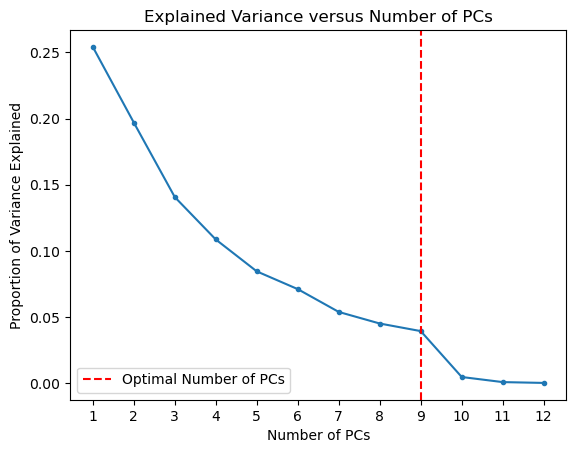

In [52]:
#plot the explained variance vs number of compoenents

#save the explained variance ratio array into a varaible
expl_var = my_PCA.explained_variance_ratio_

#plot the results
plt.figure()
plt.plot(range(1, 13), expl_var, marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1, 13, 1))
plt.title('Explained Variance versus Number of PCs')
plt.axvline(9, c='r', linestyle='--', label='Optimal Number of PCs')
plt.legend()
plt.show()

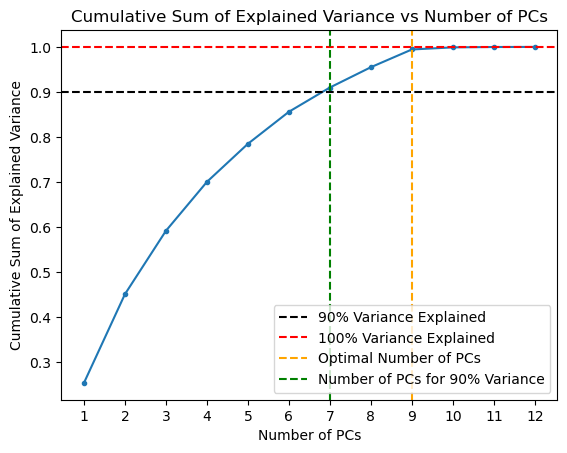

In [53]:
# plot the cumulative sum of explained variance to confirm 10 PCs is the optimal number

# Calculate the cumulative sum of this array using the 
cumulative_sum = np.cumsum(expl_var)

# Plot out the cumulative sum graph
plt.figure()
plt.plot(range(1, 13), cumulative_sum, marker='.')
plt.axhline(0.9, c='black', linestyle='--', label='90% Variance Explained')
plt.axhline(1.0, c='r', linestyle='--', label='100% Variance Explained')
plt.axvline(9, c='orange', linestyle='--', label='Optimal Number of PCs')
plt.axvline(7, c='green', linestyle='--', label='Number of PCs for 90% Variance')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.title('Cumulative Sum of Explained Variance vs Number of PCs')
plt.xticks(range(1, 13))
plt.legend()
plt.show()

---
**Observations**:

As we can see from the exploration above, the scree plot of `Explained Variance versus Number of PCs` shows that 9 PCs would be optimal as the variance provided by subsequent PCs does not change much beyond 9. However, when looking at the `Cumulative Sum of Explained Variance vs Number of PCs`, we can see that the number of PCs for at least 90% variance explained is 7 which goes upto ~100% variance at 9 PCs. So we will now do a K-fold cross validation testing number of PCs from 7 to 9 to see if we can further optimize our Logistic Regression model.

---

### Grid Search with K-fold Cross Validation with Logistic Regression Classifier number 2:

To further optimize our Logistic regression model, we will try dimensional reduction. We will use KernelPCA and PCA in a GridSearch K-fold cross validation. We will vary the number of components from 7-9 and see what the best model parameters will look like. We will also test out different kernels for KernelPCA.  We will use a cv of 5 folds and the scaled data as from the first girdsearch, Standard Scaler was the better option.


In [54]:
estimators = [('dim_reducer', PCA()),('model', LogisticRegression(random_state=42, solver = 'lbfgs', penalty='l2', C=100000.0))]

#build estimator list trat this as a placeholder
cachedir2 = mkdtemp()
pipe_logreg2=Pipeline(estimators, memory=cachedir2)

param_grid_logreg2 = [
            {'model':[LogisticRegression(random_state=42, solver = 'lbfgs', penalty='l2', C=100000.0)],
            'dim_reducer': [KernelPCA(kernel='linear'), KernelPCA(kernel='poly'), KernelPCA(kernel='rbf'), KernelPCA(kernel='sigmoid'), PCA()],
            'dim_reducer__n_components': [7, 8, 9]},

            {'model':[LogisticRegression(random_state=42, solver = 'lbfgs', penalty='l2', C=100000.0)],
             'dim_reducer': [None]}]
             

#Instantiate the GridSearch
        
grid_logreg2 = GridSearchCV(pipe_logreg2, param_grid_logreg2, cv=5, verbose=2)

#fit the grid search to the train data
fittedgrid_logreg2 = grid_logreg2.fit(X_train_scaled, y_train_sm)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END dim_reducer=KernelPCA(), dim_reducer__n_components=7, model=LogisticRegression(C=100000.0, random_state=42); total time=   3.9s
[CV] END dim_reducer=KernelPCA(), dim_reducer__n_components=7, model=LogisticRegression(C=100000.0, random_state=42); total time=   2.1s
[CV] END dim_reducer=KernelPCA(), dim_reducer__n_components=7, model=LogisticRegression(C=100000.0, random_state=42); total time=   2.1s
[CV] END dim_reducer=KernelPCA(), dim_reducer__n_components=7, model=LogisticRegression(C=100000.0, random_state=42); total time=   2.1s
[CV] END dim_reducer=KernelPCA(), dim_reducer__n_components=7, model=LogisticRegression(C=100000.0, random_state=42); total time=   2.1s
[CV] END dim_reducer=KernelPCA(), dim_reducer__n_components=8, model=LogisticRegression(C=100000.0, random_state=42); total time=   2.1s
[CV] END dim_reducer=KernelPCA(), dim_reducer__n_components=8, model=LogisticRegression(C=100000.0, random_state=42);

In [55]:
#display the best estimator
fittedgrid_logreg2.best_estimator_

Pipeline(memory='/var/folders/dp/r86j009572g6fk5d87hv187h0000gp/T/tmpd3wfue31',
         steps=[('dim_reducer', None),
                ('model', LogisticRegression(C=100000.0, random_state=42))])

---
**Observations**:

We can see from above that our best Logistic Regression model from the first and second grid search with k-fold cross validation is: 

- Logistic Regression with the following:
    - data scaled with `Standard Scaler` 
    - solver = `lbfgs`
    - regularization penalty = `l2` 
    - regularization strength `C=100000` 
    - no dimensional reduction with PCA or KernelPCA

Using these parameters, we will now test fit this model to our full training set and test set to get a final assesment for the power of our best Logistic Regression model.

Next we will use a Grid Search with K-fold cross validation on the baseline XGBoost model to see what optimization results in. We will then fit this best model to the full train and test data and compare the results of this model with the best Logistic Regression model to see what our overall best model is.

### Best Logistic Regression Model

---

Now we will fit the optimized Logistic Regression Classifier to the full train data and test data. We will then evaluate the metrics so we can compare it to the Optimized XGBoost Classification model.

In [80]:
#instantiate model with best parameteres from above
logreg_best = LogisticRegression(random_state=42, C=100000.0)

#fit the model
logreg_best.fit(X_train_full_scaled, y_train_full_sm)

#make predictions on train and test data

logreg_best_pred_train = logreg_best.predict(X_train_full_scaled)
logreg_best_pred_test = logreg_best.predict(X_test_scaled)

#compute metrics on both train and test data to determine if overfitting is occuring

#accuracy
accuracy_lg_best_train = accuracy_score(y_train_full_sm, logreg_best_pred_train)
accuracy_lg_best_test = accuracy_score(y_test, logreg_best_pred_test)

#precsion
precision_lg_best_train = precision_score(y_train_full_sm, logreg_best_pred_train, average='weighted')
precision_lg_best_test = precision_score(y_test, logreg_best_pred_test, average='weighted')

#recall
recall_lg_best_train = recall_score(y_train_full_sm, logreg_best_pred_train, average='weighted')
recall_lg_best_test = recall_score(y_test, logreg_best_pred_test, average='weighted')

#f1
f1_lg_best_train = f1_score(y_train_full_sm, logreg_best_pred_train, average='weighted')
f1_lg_best_test = f1_score(y_test, logreg_best_pred_test, average='weighted')

#confusion matrix and classification report
conf_mat_lg_best = confusion_matrix(y_test, logreg_best_pred_test)
clf_report_lg_best = classification_report(y_test, logreg_best_pred_test)


print(f"Train Accuracy: {accuracy_lg_best_train}, Test Accuracy: {accuracy_lg_best_test}")
print(f"Train Precision: {precision_lg_best_train}, Test Precision: {precision_lg_best_test}")
print(f"Train Recall: {recall_lg_best_train}, Test Recall: {precision_lg_best_test}")
print(f"Train F1 Score: {f1_lg_best_train}, Test F1 Score {f1_lg_best_test}")
print("Confusion Matrix:")
print(conf_mat_lg_best)
print("Classification Report:")
print(clf_report_lg_best)

Train Accuracy: 0.5864173228346456, Test Accuracy: 0.5427740058195927
Train Precision: 0.5804147249291278, Test Precision: 0.5498996843643941
Train Recall: 0.5864173228346456, Test Recall: 0.5498996843643941
Train F1 Score: 0.5808428867125837, Test F1 Score 0.5395156397746657
Confusion Matrix:
[[1017  439   69   40]
 [ 458  707  335   88]
 [ 150  189  647  425]
 [  52   29   83  427]]
Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.65      0.63      1565
           2       0.52      0.45      0.48      1588
           3       0.57      0.46      0.51      1411
           4       0.44      0.72      0.54       591

    accuracy                           0.54      5155
   macro avg       0.53      0.57      0.54      5155
weighted avg       0.55      0.54      0.54      5155



---
**Observations**:

As we can see from the metrics above, the model is performing similarly on the full train and test data as it did previously.  Based on the train and test accuracy, we can see that there is some overfitting but it is minimal. We will now check the AUC under the ROC curves to see how the model is performing for distinguishing each class.  As previously, we expect the model to perform quite well with disntinguishing Class 1 and Class 4 survivability as compared to other classes and that it will perform adequately for class 2 and class 3.

---

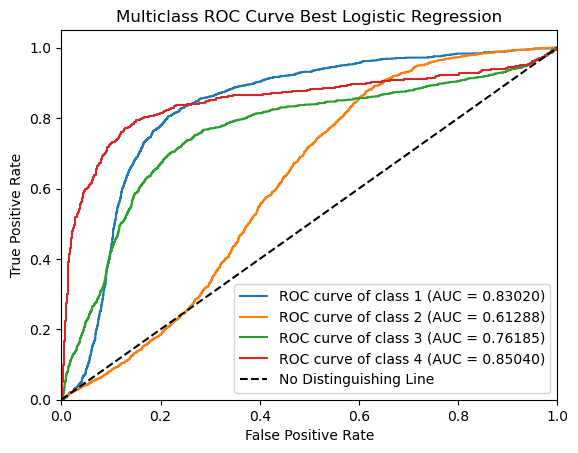

In [82]:
#check the AUC under the ROC curves

# Binarize the output
y_test_binarized_logreg_best = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized_logreg_best.shape[1]

#get the predicted probabilities with the scaled test data
y_probs_logreg_best = logreg_best.predict_proba(X_test_scaled)


#instantiate dictionaries for each metric
fpr_log = dict()
tpr_log = dict()
roc_auc_log = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr_log[i], tpr_log[i], _ = roc_curve(y_test_binarized_logreg_best[:, i], y_probs_logreg_best[:, i])
    roc_auc_log[i] = auc(fpr_log[i], tpr_log[i])

# Plot all ROC curves
plt.figure()

for i in range(n_classes):
    plt.plot(fpr_log[i], tpr_log[i], label=f'ROC curve of class {i+1} (AUC = {roc_auc_log[i]:.5f})')

#plot the no distinguishing line
plt.plot([0, 1], [0, 1], 'k--', label='No Distinguishing Line')

#format and label axis and chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve Best Logistic Regression')
plt.legend(loc="lower right")
plt.show()

---

**Observations**:

As we can see from the ROC curves and the AUC scores above, just as expected, our best Logistic Regression model is performing well for Class 1 and Class 4 and adequately for class 3, with the lowest prediction power for Class 2.  This is as expected as we saw similar results from the baseline Logistic Regression model. This model is performing adequately for what we want out of it and we can move on to optimizing the XGBoost Classifier to see if it is better than the Logistic Regression Classifier.

---

### Grid Search with K-fold Cross Validation with XGBoost Classifier:

Next we will attempt to optimize the XGBoost Classifier by tuning different hyperparameters.
- The first girdsearch will include:
    - Varying n_estimators: This is the number of boosting rounds.
    - Varying the learning_rate: Controls the contribution of each tree in the ensemble.
    - Varying the max_depth: The maximum depth of a tree.
    - We will test and optimize these using a 5 fold cross validation first as these will likely have the most impact.
    - After this Gridsearch, we will perform another one to further tune the hyperparameters with options that have less impact.



In [58]:
#GridSearch with XGBoost Classifier:
#XGBoost expacts classes start at 0 so we need to adjust them from 1-4 to 0-3
y_train_adjusted = y_train_sm - 1
y_val_adjusted = y_val - 1

#build estimator list
estimators = [('model', XGBClassifier(random_state=42))]
cachedir = mkdtemp()

#instantiate the pipe
pipe_xgb=Pipeline(estimators, memory=cachedir)

#define the parameters to search in the grid
param_grid_xgb = [{
            'model__n_estimators': [100, 200, 300, 400, 500],      
            'model__max_depth': [3, 6, 9],               
            'model__learning_rate': [0.01, 0.1, 0.2]}]


#Instantiate the GridSearch
grid_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, verbose=2)

#fit the grid search to the train data 
fittedgrid_xgb = grid_xgb.fit(X_train_scaled, y_train_adjusted)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.9s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.8s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.8s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.9s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.8s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200; total time=   1.7s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200; total time=   1.7s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200; total time=   1.7s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200; total time=   1.7s
[CV] END model__learning_rate=0.01, mo

In [59]:
#print the best parameters. as there are a lot of parameters, inorder to show the whole list we will use the following loop:
best_params = fittedgrid_xgb.best_estimator_.get_params()
for param, value in best_params.items():
    print(f"{param}: {value}")

memory: /var/folders/dp/r86j009572g6fk5d87hv187h0000gp/T/tmp57lc_607
steps: [('model', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...))]
verbose: False
model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
          

---
**Observations**:

We can see from above, the best XGBoost Classifier has:
- n_estimators = 500
- max depth = 6
- learning rate = 0.2
- the rest of the hyperparameters were defaults

We will now choose more hyperparameteres to tune:
- min_child_weight: Minimum sum of instance weight needed in a child node.
- gamma (min_split_loss): Minimum loss reduction required to make a further partition.
- subsample: The fraction of samples to be used for fitting the individual base learners.
- eval_metric: specify the evaluation metrics to be used for validation data

In [60]:
#GridSearch with XGBoost Classifier:
#XGBoost expacts classes to range from 0-1 so we need to adjust them
y_train_adjusted = y_train_sm - 1
y_val_adjusted = y_val - 1

#build estimator list
estimators_xgb_2 = [('model', XGBClassifier(random_state=42, learning_rate=0.2, max_depth=6, n_estimators=500))]
cachedir = mkdtemp()

#instantiate the pipe
pipe_xgb2=Pipeline(estimators_xgb_2, memory=cachedir)

#define the parameters to search in the grid
param_grid_xgb2 = [{
            'model__min_child_weight': [1, 3, 5],      
            'model__gamma': [0, 0.1, 0.2],               
            'model__eval_metric': ['mlogloss', 'merror', 'auc', 'aucpr'],
            'model__subsample': [0.5, 0.7, 0.9]}]


#Instantiate the GridSearch
grid_xgb2 = GridSearchCV(pipe_xgb2, param_grid_xgb2, cv=5, verbose=2)

#fit the grid search to the train data - unscaled as scaling is in our pipeline
fittedgrid_xgb2 = grid_xgb2.fit(X_train_scaled, y_train_adjusted)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END model__eval_metric=mlogloss, model__gamma=0, model__min_child_weight=1, model__subsample=0.5; total time=   9.5s
[CV] END model__eval_metric=mlogloss, model__gamma=0, model__min_child_weight=1, model__subsample=0.5; total time=   9.5s
[CV] END model__eval_metric=mlogloss, model__gamma=0, model__min_child_weight=1, model__subsample=0.5; total time=   9.4s
[CV] END model__eval_metric=mlogloss, model__gamma=0, model__min_child_weight=1, model__subsample=0.5; total time=   9.5s
[CV] END model__eval_metric=mlogloss, model__gamma=0, model__min_child_weight=1, model__subsample=0.5; total time=   9.5s
[CV] END model__eval_metric=mlogloss, model__gamma=0, model__min_child_weight=1, model__subsample=0.7; total time=   9.3s
[CV] END model__eval_metric=mlogloss, model__gamma=0, model__min_child_weight=1, model__subsample=0.7; total time=   9.3s
[CV] END model__eval_metric=mlogloss, model__gamma=0, model__min_child_weight=1, mo

In [61]:
best_params = fittedgrid_xgb2.best_estimator_.get_params()
for param, value in best_params.items():
    print(f"{param}: {value}")

memory: /var/folders/dp/r86j009572g6fk5d87hv187h0000gp/T/tmppoqe2api
steps: [('model', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...))]
verbose: False
model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=

As we can see from the above 2 gridsearches, the best parameters for the XGBoost model are as follows:
- eval_metric: mlogloss
- gamma: 0.1
- learning_rate: 0.2
- max_depth: 6
- min_child_weight: 1
- n_estimators: 500
- subsample: 0.9

We will now fit the full training data and evaluate on the test data.

In [62]:
#XGBoost expacts classes to range from 0-1 so we need to adjust them
y_train_full_adjusted = y_train_full_sm - 1
y_test_adjusted = y_test - 1

# Initialize the model
xgb_best = XGBClassifier(random_state=42, eval_metric='mlogloss', gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.9)

# Train the model
xgb_best.fit(X_train_full_scaled, y_train_full_adjusted)

# Make predictions on training and test set
preds_xgb_train = xgb_best.predict(X_train_full_scaled)
preds_xgb_test = xgb_baseline.predict(X_test_scaled)

# Compute metrics for train and test set to ensure model is not overfitting

#accuracy
accuracy_xgb_best_train = accuracy_score(y_train_full_adjusted, preds_xgb_train)
accuracy_xgb_best_test = accuracy_score(y_test_adjusted, preds_xgb_test)

#precsion
precision_xgb_best_train = precision_score(y_train_full_adjusted, preds_xgb_train, average='weighted')
precision_xgb_best_test = precision_score(y_test_adjusted, preds_xgb_test, average='weighted')

#recall
recall_xgb_best_test = recall_score(y_test_adjusted, preds_xgb_test, average='weighted')
recall_xgb_best_train = recall_score(y_train_full_adjusted, preds_xgb_train, average='weighted')

#f1
f1_xgb_best_train = f1_score(y_train_full_adjusted, preds_xgb_train, average='weighted')
f1_xgb_best_test = f1_score(y_test_adjusted, preds_xgb_test, average='weighted')

#confusion matrix and classofication report
conf_mat_xgb_best = confusion_matrix(y_test_adjusted, preds_xgb_test)
clf_report_xgb_best = classification_report(y_test_adjusted, preds_xgb_test)

# Print training metrics
print("XGBoost Best Model Metrics:")
print(f"Train Accuracy: {accuracy_xgb_best_train}, Test Accuracy: {accuracy_xgb_best_test}")
print(f"Train Precision: {precision_xgb_best_train}, Test Precision: {precision_xgb_best_test}")
print(f"Train Recall: {recall_xgb_best_train}, Test Recall: {recall_xgb_best_test}")
print(f"Train F1 Score: {f1_xgb_best_train}, Test F1 Score {f1_xgb_best_test}")
print("Confusion Matrix:")
print(conf_mat_xgb_best)
print("Classification Report:")
print(clf_report_xgb_best)

XGBoost Best Model Metrics:
Train Accuracy: 0.9898031496062992, Test Accuracy: 0.51639185257032
Train Precision: 0.9898941917702113, Test Precision: 0.516650806648813
Train Recall: 0.9898031496062992, Test Recall: 0.51639185257032
Train F1 Score: 0.9898128090362942, Test F1 Score 0.5160001499689076
Confusion Matrix:
[[944 411 143  67]
 [453 740 287 108]
 [174 416 673 148]
 [ 58  60 168 305]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59      1565
           1       0.45      0.47      0.46      1588
           2       0.53      0.48      0.50      1411
           3       0.49      0.52      0.50       591

    accuracy                           0.52      5155
   macro avg       0.51      0.52      0.51      5155
weighted avg       0.52      0.52      0.52      5155



--- 

**Observations:**

As we can see from above, though the classification report shows that the model is performing adequately, there seems to be sever overfitting as the train accuracies are very high but the test accuracies are low. This can happen with high learning rates and high number of estimators. The XGBoost GridSearch K-fold Cross Validation will cause overfitting as it will find the best parameters which will likely be those with the highest number of estimators and learning rate. As the K-fold cross validation does not take into account the difference between train and test accuracies and rather just the highest overall metrics.  

We will try to further optimize the model to prevent overfitting by adding in for early stopping and regularization and hopefully can minimize overfitting and make our model more generalizable. We can do this with the following code that will compare train and test accuracies and will find the minimum the difference between them.

---
First lets take a look at how the current train and test accuracies are looking compared to the number of estimators:

---

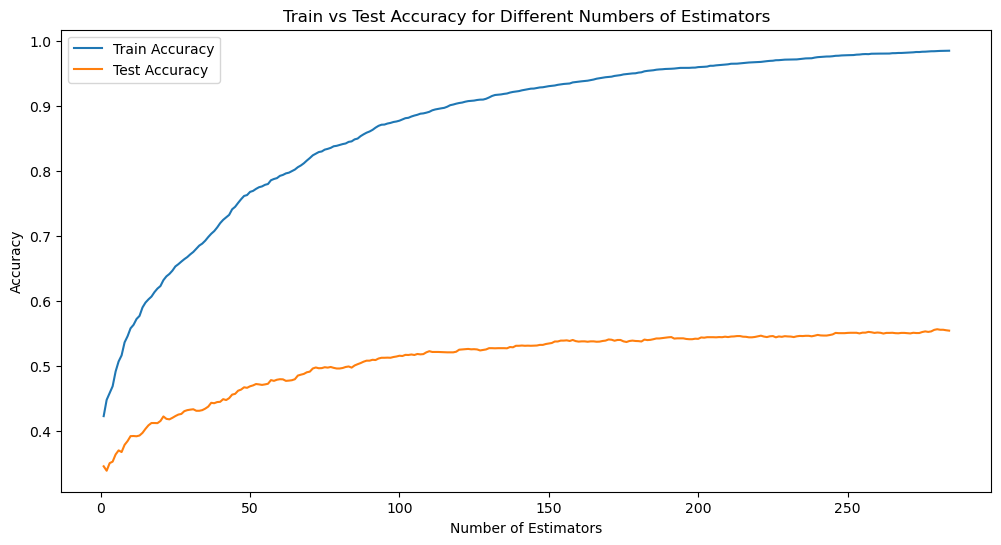

In [ ]:
#compare train vs test accuracies
# Initialize XGBoost
xgb_model = XGBClassifier(n_estimators=1000, eval_metric='mlogloss', random_state=42)

# Train with early stopping
eval_set = [(X_val, y_val_adjusted)]
xgb_model.fit(X_train_sm, y_train_adjusted, early_stopping_rounds=10, eval_set=eval_set, verbose=False)

# Get the best number of estimators
n_best_trees = xgb_model.best_iteration + 1

# Lists for accuracies
train_accuracies = []
test_accuracies = []

# Get predictions for each n_estimators
for n_estimators in range(1, n_best_trees + 1):
    train_pred = xgb_model.predict(X_train_sm, ntree_limit=n_estimators)
    test_pred = xgb_model.predict(X_test, ntree_limit=n_estimators)

    train_accuracy = accuracy_score(y_train_adjusted, train_pred)
    test_accuracy = accuracy_score(y_test_adjusted, test_pred)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(1, n_best_trees + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_best_trees + 1), test_accuracies, label='Test Accuracy')
plt.title('Train vs Test Accuracy for Different Numbers of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


---
**Observations**:

As we can see from above, there is overfitting immediately with the XGBoost model. We will try to further optimize the hyperparameters below using xgboosts built in gridsearch function that supports early stopping criteria. We will use early stopping of 10 rounds so if there is no improvement in the mlogloss for 10 round, the iteration will stop. This will allow us to further be able to tune the number of estimators and the other parameters we attempted to tune above with hopefully better results and less overfitting.

---

In [63]:
#load library for DMatrix
import xgboost as xgb

# Create a DMatrix, which is a data format that XGBoost uses for maximum efficiency
dtrain = xgb.DMatrix(X_val_scaled, label=y_val_adjusted)

# Define hyperparameter grid (adjust as needed)
param_grid = {
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.9],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Placeholder for best parameters and corresponding mean CV score
best_params = None
best_score = float("inf")

# Grid search
for max_depth in param_grid['max_depth']:
    for min_child_weight in param_grid['min_child_weight']:
        for gamma in param_grid['gamma']:
            for subsample in param_grid['subsample']:
                for learning_rate in param_grid['learning_rate']:
                    print(f"CV with max_depth={max_depth}, min_child_weight={min_child_weight}, gamma={gamma}, subsample={subsample}, learning_rate={learning_rate}")
                    
                    # Update our parameters
                    params = {
                        'max_depth': max_depth,
                        'min_child_weight': min_child_weight,
                        'gamma': gamma,
                        'subsample': subsample,
                        'learning_rate': learning_rate,
                        'eval_metric': 'mlogloss',
                        'objective': 'multi:softprob',
                        'num_class': len(np.unique(y_val_adjusted))  # Adjust based on the number of classes
                    }
                    
                    # Run CV
                    cv_results = xgb.cv(
                        params,
                        dtrain,
                        num_boost_round=500,  # Number of boosting rounds = number of estimators
                        nfold=5,  # The number of folds in CV
                        early_stopping_rounds=10,  # Stop if no improvement for 10 rounds
                        verbose_eval=False
                    )
                    
                    # Update best score
                    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
                    boost_rounds = cv_results['test-mlogloss-mean'].argmin()
                    print(f"\tMLogLoss {mean_mlogloss} for {boost_rounds} rounds")
                    
                    if mean_mlogloss < best_score:
                        best_score = mean_mlogloss
                        best_params = (max_depth, min_child_weight, gamma, subsample, learning_rate)
                        best_boost_rounds = boost_rounds
                        
print(f"Best params: {best_params}, MLogLoss: {best_score}, Best Boost Rounds: {best_boost_rounds}")


CV with max_depth=3, min_child_weight=1, gamma=0, subsample=0.5, learning_rate=0.01
	MLogLoss 1.2799994654398206 for 499 rounds
CV with max_depth=3, min_child_weight=1, gamma=0, subsample=0.5, learning_rate=0.1
	MLogLoss 1.2579420330359956 for 193 rounds
CV with max_depth=3, min_child_weight=1, gamma=0, subsample=0.5, learning_rate=0.2
	MLogLoss 1.2693087901587203 for 88 rounds
CV with max_depth=3, min_child_weight=1, gamma=0, subsample=0.7, learning_rate=0.01
	MLogLoss 1.2811908764151763 for 499 rounds
CV with max_depth=3, min_child_weight=1, gamma=0, subsample=0.7, learning_rate=0.1
	MLogLoss 1.2508827415093076 for 246 rounds
CV with max_depth=3, min_child_weight=1, gamma=0, subsample=0.7, learning_rate=0.2
	MLogLoss 1.2563563539705125 for 135 rounds
CV with max_depth=3, min_child_weight=1, gamma=0, subsample=0.9, learning_rate=0.01
	MLogLoss 1.2839960487315007 for 499 rounds
CV with max_depth=3, min_child_weight=1, gamma=0, subsample=0.9, learning_rate=0.1
	MLogLoss 1.24996804255051

In [64]:
#show best parameters, score and boost rounds
print(f"Best params: {best_params}, MLogLoss: {best_score}, Best Boost Rounds: {best_boost_rounds}")


Best params: (3, 3, 0.1, 0.9, 0.1), MLogLoss: 1.236782702488342, Best Boost Rounds: 411


---
**Observations**:

The best paramaters found from the above XGBoost cv is:
- max depth = 3
- min_child_weight = 3
- gamma = 0.1
- subsample = 0.9
- learning rate = 0.1
- Number of estimators/boosting rounds = 411

These gave us the minimum mlogloss.  Lets try fitting our XGB classifier with these parameters and see how it performs

---


In [74]:
# Best hyperparameters and boosting rounds from grid search
best_max_depth = 3
best_min_child_weight = 3
best_gamma = 0.1
best_subsample = 0.9
best_learning_rate = 0.1
best_n_estimators = 411

# Initialize the XGBoost model with the best hyperparameters
final_xgb_model = xgb.XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    eval_metric='mlogloss',
    random_state=42
)


# Train the model
final_xgb_model.fit(X_train_full_scaled, y_train_full_adjusted)

# Make predictions on training and test set
preds_xgb_train = final_xgb_model.predict(X_train_full_scaled)
preds_xgb_test = final_xgb_model.predict(X_test_scaled)

# Compute metrics for train and test set to ensure model is not overfitting

#accuracy
accuracy_xgb_best_train = accuracy_score(y_train_full_adjusted, preds_xgb_train)
accuracy_xgb_best_test = accuracy_score(y_test_adjusted, preds_xgb_test)

#precsion
precision_xgb_best_train = precision_score(y_train_full_adjusted, preds_xgb_train, average='weighted')
precision_xgb_best_test = precision_score(y_test_adjusted, preds_xgb_test, average='weighted')

#recall
recall_xgb_best_test = recall_score(y_test_adjusted, preds_xgb_test, average='weighted')
recall_xgb_best_train = recall_score(y_train_full_adjusted, preds_xgb_train, average='weighted')

#f1
f1_xgb_best_train = f1_score(y_train_full_adjusted, preds_xgb_train, average='weighted')
f1_xgb_best_test = f1_score(y_test_adjusted, preds_xgb_test, average='weighted')

#confusion matrix and classofication report
conf_mat_xgb_best = confusion_matrix(y_test_adjusted, preds_xgb_test)
clf_report_xgb_best = classification_report(y_test_adjusted, preds_xgb_test)

# Print training metrics
print("XGBoost Best Model Metrics:")
print(f"Train Accuracy: {accuracy_xgb_best_train}, Test Accuracy: {accuracy_xgb_best_test}")
print(f"Train Precision: {precision_xgb_best_train}, Test Precision: {precision_xgb_best_test}")
print(f"Train Recall: {recall_xgb_best_train}, Test Recall: {recall_xgb_best_test}")
print(f"Train F1 Score: {f1_xgb_best_train}, Test F1 Score {f1_xgb_best_test}")
print("Confusion Matrix:")
print(conf_mat_xgb_best)
print("Classification Report:")
print(clf_report_xgb_best)

XGBoost Best Model Metrics:
Train Accuracy: 0.6281889763779528, Test Accuracy: 0.48031037827352085
Train Precision: 0.6257672864013969, Test Precision: 0.48649952008114994
Train Recall: 0.6281889763779528, Test Recall: 0.48031037827352085
Train F1 Score: 0.6225609240085291, Test F1 Score 0.4800582402234776
Confusion Matrix:
[[804 465 179 117]
 [426 771 237 154]
 [197 460 567 187]
 [ 56  65 136 334]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.51      0.53      1565
           1       0.44      0.49      0.46      1588
           2       0.51      0.40      0.45      1411
           3       0.42      0.57      0.48       591

    accuracy                           0.48      5155
   macro avg       0.48      0.49      0.48      5155
weighted avg       0.49      0.48      0.48      5155



---
**Observations:**

As we can see from the metrics above, by further tuning the hyperparameters, the model has much less overfitting occuring.  There still appears to be some as the train vs test metrics are not as close as I would like them to be.  However, we will move on to evaluating the ROC curves and the AUC values for this model to see how it fares compared to our optimized Logistic Regression Classifier.

There needs to be further hyperparameter optimization to prevent overfitting here. This gridsearch was extremely computationally expensive and too a long time to run. We will stop attempting to further tune this model here. because even though we are getting less overfitting, we are decreasing in accuracy and f1 as compared to our baseline models, so it does not seem like XGBoost classifier is the best for this data set.

---

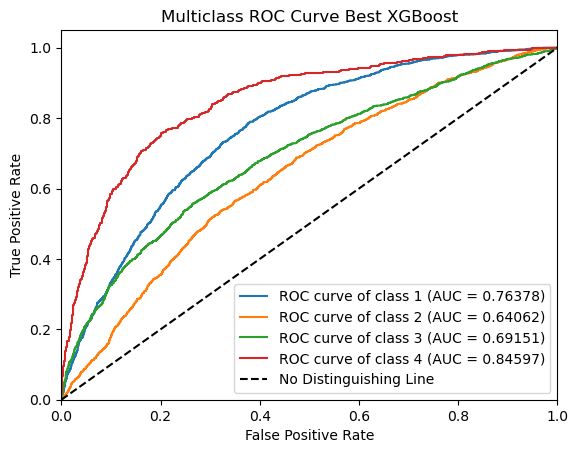

In [78]:
#check the AUC under the ROC curves

# Binarize the output
y_test_binarized_xgb = label_binarize(y_test_adjusted, classes=np.unique(y_test_adjusted))
n_classes = y_test_binarized_xgb.shape[1]

#get the predicted probabilities
y_probs_xgb_best = final_xgb_model.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
#instantiate dictionaries for each metric
fpr_xgb = dict()
tpr_xgb = dict()
roc_auc_xgb = dict()

for i in range(n_classes):
    fpr_xgb[i], tpr_xgb[i], _ = roc_curve(y_test_binarized_xgb[:, i], y_probs_xgb_best[:, i])
    roc_auc_xgb[i] = auc(fpr_xgb[i], tpr_xgb[i])

# Plot all ROC curves
plt.figure()

#a for loop to go through the classes
for i in range(n_classes):
    plt.plot(fpr_xgb[i], tpr_xgb[i], label=f'ROC curve of class {i+1} (AUC = {roc_auc_xgb[i]:.5f})')

#plot the no distinguishing line
plt.plot([0, 1], [0, 1], 'k--', label='No Distinguishing Line')

#format and label axis and chart
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve Best XGBoost')
plt.legend(loc="lower right")
plt.show()

## Comparison of Baseline and Optimized models: <a class="anchor" id="compare"></a>

---

Below, we will plot the Baseline and tuned models for XGBoost and Logistic Regression to compare them and see which should be the one we should use:

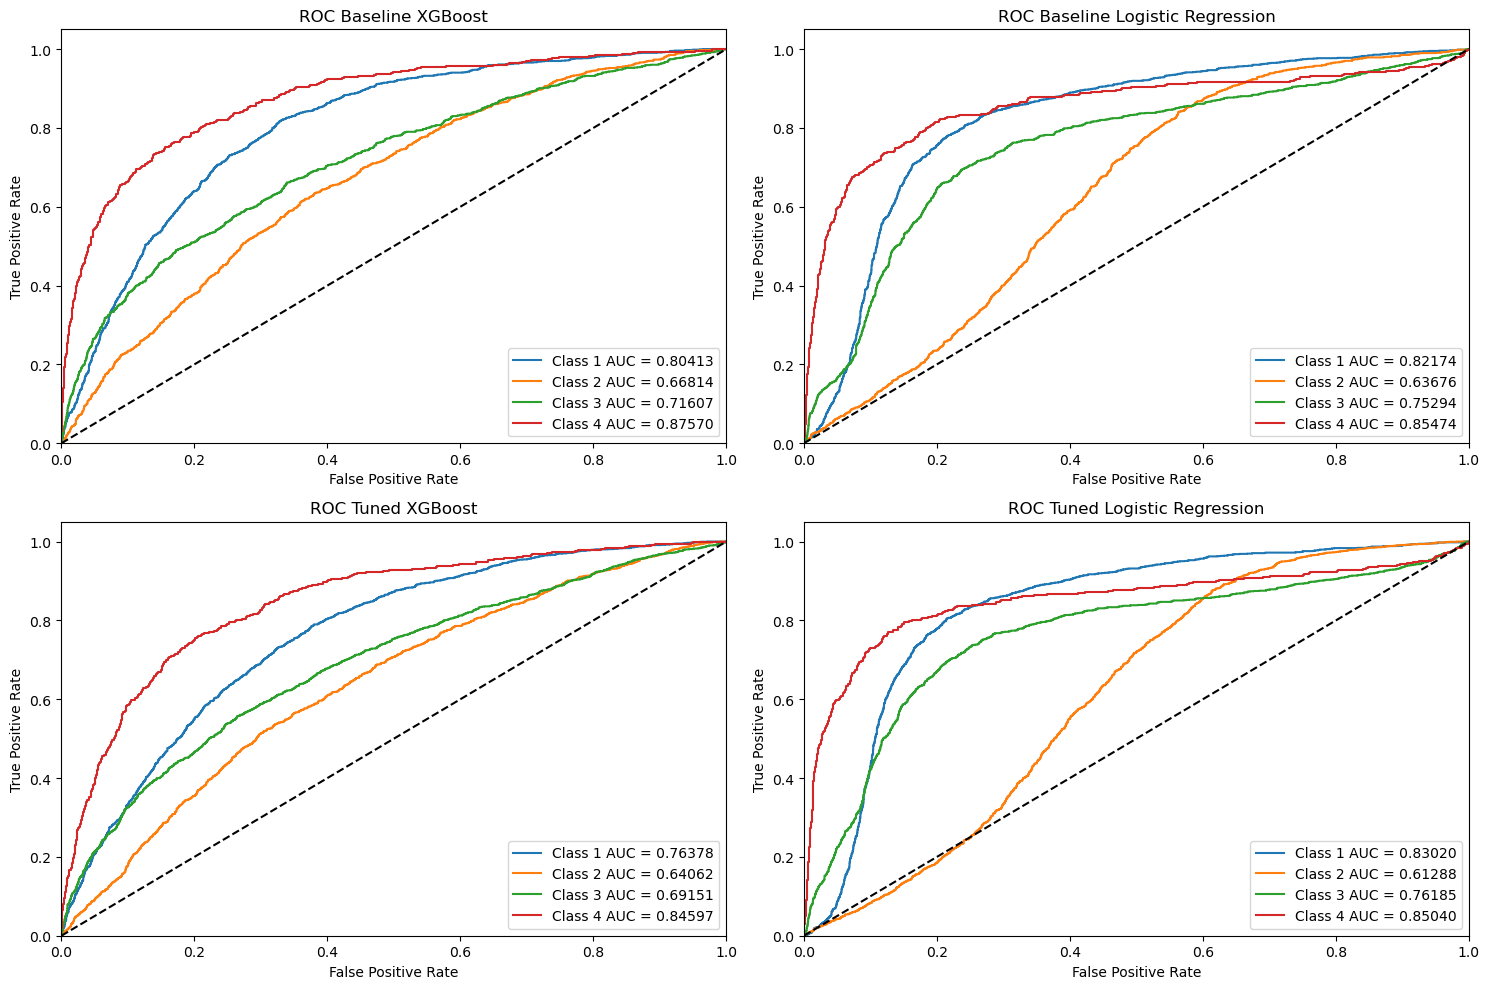

In [89]:
# Compute ROC curve and AUC for each class for XGBoost Baseline

#instantiate empty dictionaries for each metric
fpr_xgb_base = dict()
tpr_xgb_base = dict()
roc_auc_xgb_base = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr_xgb_base[i], tpr_xgb_base[i], _ = roc_curve(y_val_binarized_xgb[:, i], y_probs_xgb_baseline[:, i])
    roc_auc_xgb_base[i] = auc(fpr_xgb_base[i], tpr_xgb_base[i])

#----------------------------------------------#

# Compute ROC curve and ROC area for each class for XGBoost best model

#instantiate empty dictionaries for each metric
fpr_xgb = dict()
tpr_xgb = dict()
roc_auc_xgb = dict()

for i in range(n_classes):
    fpr_xgb[i], tpr_xgb[i], _ = roc_curve(y_test_binarized_xgb[:, i], y_probs_xgb_best[:, i])
    roc_auc_xgb[i] = auc(fpr_xgb[i], tpr_xgb[i])

#----------------------------------------------#

# Compute ROC curve and ROC area for each class for Logistic Regression baseline model

#instantiate empty dictionaries for each metric
fpr_log_base = dict()
tpr_log_base = dict()
roc_auc_log_base = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr_log_base[i], tpr_log_base[i], _ = roc_curve(y_val_binarized_logreg_baseline[:, i], y_probs_logreg_baseline[:, i])
    roc_auc_log_base[i] = auc(fpr_log_base[i], tpr_log_base[i])

#------------------------------------------------#

# Compute ROC curve and ROC area for each class for Logistic Regression best model

#instantiate empty dictionaries for each metric
fpr_log = dict()
tpr_log = dict()
roc_auc_log = dict()

for i in range(n_classes):
    fpr_log[i], tpr_log[i], _ = roc_curve(y_test_binarized_logreg_best[:, i], y_probs_logreg_best[:, i])
    roc_auc_log[i] = auc(fpr_log[i], tpr_log[i])

#------------------------------------------------#
# Create a figure with 4 subplots
plt.figure(figsize=(15, 10))

# Plot ROC curves for XGBoost baseline model
plt.subplot(2, 2, 1)  # 2 row, 2 columns, subplot 1
for i in range(n_classes):
    plt.plot(fpr_xgb_base[i], tpr_xgb_base[i], label=f'Class {i+1} AUC = {roc_auc_xgb_base[i]:.5f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Baseline XGBoost')
plt.legend(loc="lower right")


# Plot ROC curves for XGBoost best model
plt.subplot(2, 2, 3)  # 2 row, 2 columns, subplot 3
for i in range(n_classes):
    plt.plot(fpr_xgb[i], tpr_xgb[i], label=f'Class {i+1} AUC = {roc_auc_xgb[i]:.5f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Tuned XGBoost')
plt.legend(loc="lower right")


# Plot ROC curves for Logistic Regression baseline model
plt.subplot(2, 2, 2)  # 2 row, 2 columns, subplot 4
for i in range(n_classes):
    plt.plot(fpr_log_base[i], tpr_log_base[i], label=f'Class {i+1} AUC = {roc_auc_log_base[i]:.5f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Baseline Logistic Regression')
plt.legend(loc="lower right")


# Plot ROC curves for Logistic Regression best model
plt.subplot(2, 2, 4)  # 2 row, 2 columns, subplot 4
for i in range(n_classes):
    plt.plot(fpr_log[i], tpr_log[i], label=f'Class {i+1} AUC = {roc_auc_log[i]:.5f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Tuned Logistic Regression')
plt.legend(loc="lower right")

plt.tight_layout()  # Adjust the layout
plt.show()


**Overall Best Model**:

---
If we consider the best AUC values across all classes and models, the optimized logistic regression model seems to perform overall the best over the 4 classes. It performs the best for class 1 which is very important for the model to be able to predict and it performs decently well on class 4 which is also very important to predict. Yes the XGBoost baseline model does do a better job at predicting class 4 than the rest of the models, but it lacks in predictive power for class 1 and class 3 as compared to the tuned Logistic Regression Classifier. It is important to consider the balance of performance across all classes. The logistic regression models show the least variation in performance across all classes indicating a consistent model and therefore may be more generalizable with new data. The balance of performance for class 1 and class 4 is important and therefore I believe the Optimized Logistic Regression model is the best from all this exploration.  Also another factor to consider is that the XGBoost model is much more compuationally costly and more complex than the simple Logistic Regression model. This ourweights the slight increase in performance of the XGBoost Model in class 4 as it would be much more costly to retrain and maintain as new data emerged. I believe with different features and more patient data, we could improve the performance of the Optimized Logistic Regression Model.

Below, we will plot the values of the coefficients for each class for the Optimized Logistic Regression model as we are deciding that this is the best model moving forward.  Since we did not do any dimensional reduction, we can directly see what features contirbute positiveley or negatively to the power of the model to predict each class. We will haave 4 plots one for each class as this will help us see where the model gets and loses its power from for each class. 

---

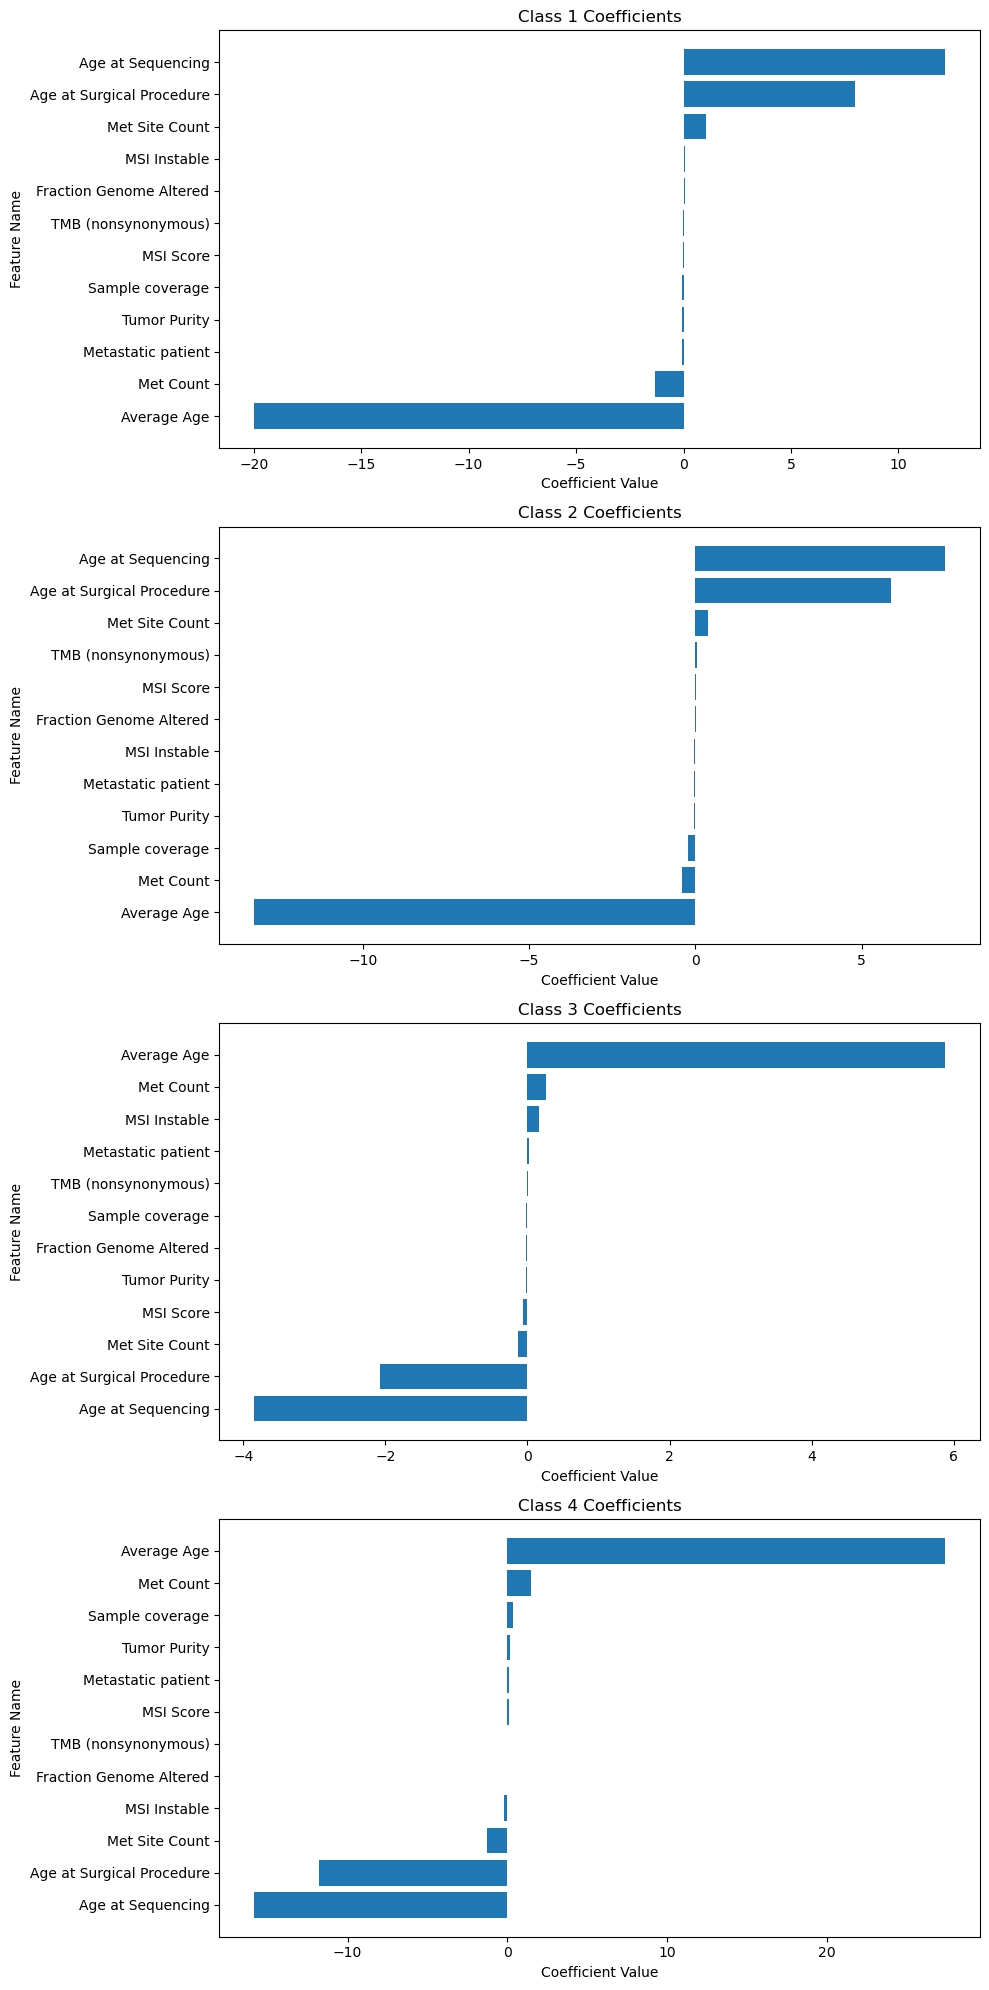

In [96]:
# Number of classes
num_classes = logreg_best.coef_.shape[0]

# Create a figure with a subplot for each class
fig, axes = plt.subplots(num_classes, 1, figsize=(10, num_classes * 5))

#get the feature names from the original dataframe
feature_names = X_train_full.columns


# Plot the coefficients for each class
for i in range(num_classes):
    # Sort the coefficients
    sorted_idx = logreg_best.coef_[i].argsort()
    
    axes[i].barh(range(len(sorted_idx)), logreg_best.coef_[i][sorted_idx], align='center')
    axes[i].set_yticks(range(len(sorted_idx)))
    axes[i].set_yticklabels(feature_names[sorted_idx])
    axes[i].set_title(f'Class {i+1} Coefficients')
    axes[i].set_xlabel('Coefficient Value')
    axes[i].set_ylabel('Feature Name')
    
plt.tight_layout()
plt.show()


---
**Observations**:

As we can see from the coefficeints for each class, we can see age has the largest contribution in both positive and negative way depending on what class we are looking at. This is why these needed to be in here, as they contribute power to the model depending on what class we are looking at. We can see that the number of mets and the number of met sites also have a significant impact. In some classes it has a positive impact and others a negative impact.  This makes sense as a low number of metastatic tumors or site, would mean a better prognosis as they their disease has not progressed to a worst stage. The more mets, the more progressed and agressive the disease.  We can see that some features did not seem to impact the results as much.  They do have postive or negative coefficients and can contribute but they are less impactful.  They are a bit difficult to see on the above charts due to the scale of some of these coefficients. They are less impactiful but arguably important to the feature space and the predictive power of the model given that this is a multiclass problem.

--


## Conclusions <a class="anchor" id="conclude"></a>

---

Throughout this journey, we tested 6 different baseline models and then optimized the hyperparameters of the 2 models that were doing comparably well as the others were quite poor.

We will compare the 2 models that we found were the best in Baseline testing and see how they performed after optimzing using hyperparameter tuning. The models we will compare are:
- `Multiclass Logistic Regression`
- `XGBoost Classifier`

**Baseline XGBoost vs. Optimized XGBoost**:

- The baseline XGBoost model seems to perform better than the optimized model for all classes as indicated by the higher AUC (Area Under the Curve) values.

**Baseline Logistic Regression vs. Tuned Logistic Regression**:

- The tuned Logistic Regression model shows an improvement over the baseline model for class 1, as the AUC is higher.
- For class 2 and 4, the AUC is slightly lower in the optimized model than in the baseline.
- For class 3, the AUC is slightly higher in the optimized model versus the baseline
- Class 4's performance remains relatively similar between the baseline and tuned Logistic Regression models with a slight decrease in the optimized model.

**XGBoost vs. Logistic Regression**:

Comparing the baseline models of XGBoost and Logistic Regression 
- XGBoost appears to have better performance for class 2 and class 4.
- Logistic Regression performs better for class 1 and class 3.

When comparing the optimized XGBoost and Logistic Regression models

- the tuned XGBoost has higher AUCs only for class 2
- the tuned Logistic Regression model performs better for classes 1, 3 and 4

---
## Next Steps <a class="anchor" id="next"></a>

---

Ideally, moving forward we could use a hybrid model that consists of elements from both the baseline XGBoost Classifier and the optimized Logistic Regression model that could improve the performance for the classes we are lacking good discrimanative power (Class 1 and 3).  

The Model trained had adequate predictive power, however next steps from here include:
- Designing a neural network (from scratch or using transfer learning) to get even more powerful predictions.
- Collecting more patient data and further engineering my feature space for more predictive power.
- Gathering a wider feature space to have more variance in the features present.
- Ideally including more descriptive features that could aid in predicitve power. 

Features I believe would help create an even better model are:
  - Tumor size.
  - Metastases size.
  - Specific mutated genes (there are a variety of genes that can be mutated that indicate prognosis status).
  - Treatment (what treatment the patient is on can drastically change their prognosis).
  - Tumor excision status: was the primary or metastatic tumors excised fully, partially, not at all? - if the tumor has been removed, this can change the patients prognosis.
  
Moving forward, I would like to continue to work on this project and make the model perform even better and maybe integrate more features and more patient data. I will also attempt to create a streamlit app and a dashboard to display my project and results thus far.


In [97]:
#download best model as pkl file for streamlit

import joblib

# save the optimized LogisticRegression model
joblib.dump(logreg_best, 'logreg_best_model.pkl')


['logreg_best_model.pkl']